# Thermal Modeling

Different thermal models are built using different techniques and are evaluated based on standard measures. The different techniques used to build the thermal model are:
Linear Regression (with and without Principal Component Analysis)
Lasso Regression
Long Short Term Memory(LSTM) 

These techniques are applied to the dataset of different buildings and of both first(data containing current timestep only) and second order(data containing current and previous timestep). 

Importing required standard libraries

In [2]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Importing required libraries for LSTM

In [3]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


# Regression

Build Linear and Lasso Regression model using Scikit-learn library

In [4]:
from sklearn.linear_model import LinearRegression

def linearRegression(train_X, train_y,test_X,test_y):
    ''' Build a linear regression model.
        Parameters: Train and test dataset
        Return: Linear regression model
    '''
    
    #Build the model using training dataset
    linearModel = LinearRegression().fit(train_X, train_y)
    #Apply the model to test dataset to predict the temperature
    test_pred = linearModel.predict(test_X)
    #Find RMSE of the above predictions
    rmse = sqrt(mean_squared_error(test_y,test_pred))
    #print(rmse)
    
    return linearModel

from sklearn import linear_model

def lassoRegression(train_X, train_y,test_X,test_y):
    ''' Build a lasso regression model.
        Parameters: Train and test dataset
        Return: Lasso regression model
    '''
    
    lasso_clf = linear_model.Lasso(alpha=0.1)
    #Build the model using training dataset
    lasso_clf.fit(train_X, train_y)
    #Apply the model to test dataset to predict the temperature
    test_pred = lasso_clf.predict(test_X)
    #Find RMSE of the above predictions
    rmse = sqrt(mean_squared_error(test_y,test_pred))
    #print(rmse)
    
    return lasso_clf


In [5]:
def forecasting(test_X, test_y, start_time, duration, model, second_order):
    ''' Autoforecasts a sample data of test data using Regression models (without PCA). 
    Parameters: test data, start time index, duration till when the forecasting is to be done, 
                regression model, maximum t_in value, indicator variable for second order
    Return: List of errors of the predictions made for a particular sample dataset'''
    
    predictions_i = []
    errs_i = []
    curr_time = start_time
    #End time index gives till what time autoforecasting is done
    end_time = start_time + datetime.timedelta(minutes=duration)
    while curr_time <= end_time:
        # If current time is not present in test data index then return None
        if curr_time not in test_X.index:
            return None
        
        #Make a copy of the row of test data having curr_time as its index
        input_x = test_X.loc[curr_time].copy()
        
        #Previous prediction made is set as t_in for cur_time index data
        if second_order == 1:
            if len(predictions_i) < 2:
                predictions_i.append(input_x['t_in'])
            else:
                input_x['t_in'] = predictions_i[-1]
                input_x['t_in(t-5)'] = predictions_i[-2]
        else:
            if predictions_i:
                input_x['t_in'] = predictions_i[-1]
                
        #Prediction is made for the curr_time row data
        y = model.predict([input_x])
        predictions_i.append(y[0])
        #Error is calculated by finding the difference of actual and predicted value of test data
        errs_i.append(test_y.loc[curr_time] - y[0])
        curr_time = curr_time + datetime.timedelta(minutes=5)
        
    return errs_i

In [6]:
def forecastingPCA(testX, testY, start, duration, modelObj, second_order):
    ''' Autoforecasts a sample data of test data using Regression models with effect of PCA. 
    Parameters: test data, start time index, duration till when the forecasting is to be done, 
                pca object, maximum t_in value, indicator variable for second order
    Return: List of errors of the predictions made for a particular sample '''
    
    predictions_i = []
    errs_i = []
    curr_time = start
    #End time index gives till what time autoforecasting is done
    end_time = start + datetime.timedelta(minutes=duration)
    while curr_time <= end_time:
        # If current time is not present in test data index then return None
        if curr_time not in testX.index:
            return None
        
        #Make a copy of the row of test data having curr_time as its index
        input_x = testX.loc[curr_time].copy()
        
        #Previous prediction made is set as t_in for cur_time index data
        if second_order == 1:
            if len(predictions_i) < 2:
                predictions_i.append(input_x['t_in'])
            else:
                input_x['t_in'] = predictions_i[-1]
                input_x['t_in(t-5)'] = predictions_i[-2]
        else:
            if predictions_i:
                input_x['t_in'] = predictions_i[-1]
                
        input_x_values = input_x.values
        # The input row is standardised and transformed according to pca 
        input_x_scaled = modelObj.scaler.transform(input_x_values.reshape(1,-1))
        input_x_pca = modelObj.pca.transform(input_x_scaled)
        
        #Prediction is made for the curr_time row data
        y = modelObj.pcaLinearModel.predict(input_x_pca)
        predictions_i.append(y[0])
        #Error is calculated by finding the difference of actual and predicted value of test data
        errs_i.append(testY.loc[curr_time] - y[0])
        curr_time = curr_time + datetime.timedelta(minutes=5)
        
    return errs_i

In [7]:
def forecastingLSTM(testX_df, testY_df, start_time, duration, model, maxT_in, second_order):
    ''' Autoforecasts a sample data of test data using LSTM model. 
    Parameters: test data, start time index, duration till when the forecasting is to be done, 
                lstm model, maximum t_in value, indicator variable for second order
    Return: List of errors of the predictions made for a particular sample '''
    
    predictions_i = []
    errs_i = []
    curr_time = start_time
    #End time index gives till what time autoforecasting is done
    end_time = start_time + datetime.timedelta(minutes=duration)
    while curr_time <= end_time:
        # If current time is not present in test data index then return None
        if curr_time not in testX_df.index:
            return None
        
        #Make a copy of the row of test data having curr_time as its index
        input_x = testX_df.loc[curr_time].copy()
        
        #Previous prediction made is seat as t_in for cur_time index data
        if second_order == 1:
            if len(predictions_i) < 2:
                predictions_i.append(input_x['t_in'])
            else:
                input_x['t_in'] = predictions_i[-1]
                input_x['t_in(t-5)'] = predictions_i[-2]
            reshape_param = 2
        else:
            if predictions_i:
                input_x['t_in'] = predictions_i[-1]
            reshape_param = 1
            
        inputX_values = input_x.values
        #Reshape the row accordingly to apply model
        inputX_values = inputX_values.reshape(1,reshape_param,5)
        
        #Prediction is made for the curr_time row data
        y = model.predict([inputX_values])
        predictions_i.append(y[0])
        #Error is calculated by finding the difference of actual and predicted value of test data
        errs_i.append(testY_df.loc[curr_time]*maxT_in - y[0]*maxT_in)
        curr_time = curr_time + datetime.timedelta(minutes=5)
    
    return errs_i

In [8]:
from scipy.stats import sem
def getErrors(testX, testY, startList, duration, model, maxT_in, method, second_order=0):
    ''' Calls the autoforecasting function to get the errors for given samples of test data. 
         Different error metrics are calculated from the errors obtained from autoforecasting
    Parameters: test data, list of time index indicating starting point for samples, 
                duration till when autoforecasting is done, model built to make predictions, maximum t_in value,
                method indicates if its lstm or regression(with or without pca), indicator variable for second order data
    Return: RMSE, MSE, SEM for each interval '''
    
    errs = []
    if method == "lstm":
        #Run the autoforecasting using LSTM model for different samples of data
        for start in startList:
            #Errors collected from each sample is stored as a Series object and appended to a list called errs.
            errs_i = forecastingLSTM(testX, testY, start, duration, model, maxT_in, second_order)
            if errs_i:
                errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
    elif method == "regression":
        #Run the autoforecasting using regression models for different samples of data
        for start in startList:
            #Errors collected from each sample is stored as a Series object and appended to a list called errs.
            errs_i = forecasting(testX, testY, start, duration, model, second_order)
            if errs_i:
                errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
    elif method == "pca":
        #Run the autoforecasting using regression models with the effect of PCA for different samples of data
        for start in startList:
            #Errors collected from each sample is stored as a Series object and appended to a list called errs.
            errs_i = forecastingPCA(testX, testY, start, duration, model, second_order)
            if errs_i:
                errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
    
    
    final_errors = []
    mean_errors = []
    sem_errors = []
    
     #Calculates different error metrics for each interval.
    for i in range(int(duration/5)):
        ei = np.array([])
        for e in errs:
            ei = np.append(ei, e.loc[i]*e.loc[i])
        #Calculates the root mean squared error
        final_errors.append(sqrt(np.mean(ei)))
        #Calculates the mean squared error
        mean_errors.append(np.mean(ei))
        #Calculates the standard error of mean
        sem_errors.append(sem(ei))
        
    #plt.errorbar(x=range(len(mean_errors)), y=mean_errors, yerr=sem_errors)
    #plt.show
    return final_errors, mean_errors, sem_errors, errs

# Data Preprocessing 

In [9]:
def readPickleData(filepath):
    ''' Dataset is read from a pickle file.
    Parameters: Location where the data file is stored
    Return: Data read from pickle file '''
    
    with open(filepath, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            data = u.load()
    return data
            
def preProcessingData(data, interval, second_order):
    ''' Data collected is further preprocessed to handle the missing data, 
        transform  data for second order data and handle action feature.
        Parameters: data collected, interval at which the prediction is made, indicator variable for second order
        Return: preprocessed data
    '''
    
    #Converts the categorical value range from 0-5 to 0-2 for action feature
    def f(x):
            if x == 0:
                return 0
            elif x == 2 or x == 5:
                return 2
            elif x ==1 or x == 3:
                return 1

    #Construct a feature 'action_heating' and its value is 1 if action is heating else 0
    def h(x):
            if x == 1:
                return 1
            else:
                return 0

    #Construct a feature 'action_cooling' and its value is 1 if action is cooling else 0
    def c(x):
            if x == 2:
                return 1
            else:
                return 0

    data["action"] = data["action"].map(f)
    data['action_heating'] = data["action"].map(h)
    data['action_cooling'] = data['action'].map(c)
        
    #Drop unwanted features
    data = data.drop([ 'action', 'action_prev', 'action_duration'], axis=1)
    
    #Transform the dataset to second order by adding same features having values of previous timestep 
    if second_order==1:
        for col in data:
            last_temps = []

            last_temp = None
            curr_time = data.index[0]
            for index, row in data.iterrows():

                if last_temp is None:
                    last_temps.append(row[col])  # so the feature will be zero instead
                else:
                    last_temps.append(last_temp)

                if curr_time == index:
                    last_temp = row[col]
                    curr_time += datetime.timedelta(seconds=row["dt"])
                else:
                    last_temp = None
                    curr_time = index + datetime.timedelta(seconds=row["dt"])

            data[col+'(t-5)'] = np.array(last_temps)
        data = data.drop(['dt(t-5)'], axis=1)
       
    #Choose the dataset such that the time gaps are set equal to the interval time
    data = data[data["dt"] == interval*60]
    data = data.drop(['dt'], axis=1)
    #Drop missing values
    data = data.dropna()
    
    return data       
        

In [10]:
def splitData(processed_data, secondOrder=0):
    ''' The processed data is split into 70% of training and 30% of testing dataset. 
        Each of these datasets are further split into target and features variables.
        Parameters: Processed dataset, indicator variable for second_order
        Return: Features and target variables for training and testing dataset
    '''
    
    ratio = int(0.7 * processed_data.shape[0])
    train = processed_data.iloc[:ratio]
    test = processed_data.iloc[ratio:]
    if secondOrder==1:
        second_train_y = train['t_next'] #target variable
        second_train_X = train.drop(['t_next', 't_next(t-5)'], axis=1) #remaining variables are features
        second_test_y = test['t_next']
        second_test_X = test.drop(['t_next', 't_next(t-5)'], axis=1)
        return second_train_X,second_train_y,second_test_X,second_test_y 
    train_y = train['t_next'] #target variable
    train_X = train.drop(['t_next'], axis=1)  #remaining variables are features
    test_y = test['t_next']
    test_X = test.drop(['t_next'], axis=1)
    
    return train_X,train_y,test_X,test_y

In [11]:
def scaling(data):
    ''' The values of each feature in dataset are converted to a range 0 to 1 
        by dividing the value with the maximum value of that feature (used for inverting the scalling).
        Parameters: processed data
        Return: converted dataset, list of maximum values of all the features
    '''
    maxValues = []
    scaled = np.empty([data.shape[0], data.shape[1]])
    numSamples = data.shape[0]
    numFeatures = data.shape[1]
    dataValues = data.values
    dataValues = dataValues.astype('float32')
    for i in range(numFeatures):
        maxNum = max(dataValues[:,i])
        maxValues.append(maxNum)
        for j in range(numSamples):
            scaled[j,i] = dataValues[j,i]/maxNum
    return scaled, maxValues

In [12]:
def reshapeData(trainX, trainY, testX, testY, second_order=0):
    ''' Dataset is reshaped from [samples, features] to [samples, timeframe, features] where
        samples - number of observations(row) in dataset
        timeframe - order of dataset (first order=1, second order=2)
        features - number of attributes(columns) in dataset
        Parameters: Features and target variables of training and testing dataset, indicator variable for second_order
        Return: Reshaped numpy array of features and target variables of training and testing dataset
    '''
    
    if second_order == 1:
        param = 2
    else:
        param = 1
    lstm_train_X = trainX.values.reshape((trainX.shape[0], param, 5))
    lstm_test_X = testX.values.reshape((testX.shape[0], param, 5))
    lstm_train_y = trainY.values
    lstm_test_y = testY.values
    print(lstm_train_X.shape, lstm_train_y.shape, lstm_test_X.shape, lstm_test_y.shape)
    return lstm_train_X, lstm_test_X,lstm_train_y, lstm_test_y

In [13]:
class PrincipalComponentAnalysis:
    #Construct an object containing target and features of both test and train dataset
    def __init__(self, trainX, trainY, testX, testY):
        self.trainX = trainX
        self.trainY = trainY
        self.testX = testX
        self.testY = testY
    
    #Standardize the dataset using StandardScaler and transform the dataset according to the principal components.
    def scaleAndPca(self):
        #Store the Standard scaler object as an attribute of PrincipalComponentAnalysis object
        self.scaler = StandardScaler()
        self.scaler.fit(self.trainX)
        train_scaled = self.scaler.transform(self.trainX)
        test_scaled = self.scaler.transform(self.testX)

        #Store the PCA object as an attribute of PrincipalComponentAnalysis object
        self.pca = PCA(0.95)
        self.pca.fit(train_scaled)
        train_pca = self.pca.transform(train_scaled)
        test_pca = self.pca.transform(test_scaled)

        #Build a linear regression model using the PCA data
        self.pcaLinearModel = linearRegression(train_pca,self.trainY, test_pca, self.testY)
    
        return self

In [14]:
def building(filepath, lstm1file, lstm2file):
    '''Reads the data from the give filepath and preprocess the data. Different methods are used to 
        build the models and are evaluated based on standard error metrics
        Parameters: location of data file and selected LSTM model pickle file.
        Return: RMSE, MSE, SEM
    '''
    
    #Read dataset and preprocess it
    data = readPickleData(filepath)
    data = data.drop(data.iloc[:, 8:], axis=1)
    processed_data = preProcessingData(data, 5, 0)
    second_processed_data = preProcessingData(data, 5, 1)
    #Split the dataset
    train_X,train_y,test_X,test_y = splitData(processed_data)
    second_train_X,second_train_y,second_test_X,second_test_y = splitData(second_processed_data,1)

    #Build Regression model for first order dataset
    linearModel = linearRegression(train_X,train_y, test_X, test_y)
    lassoModel = lassoRegression(train_X, train_y, test_X, test_y)

    #Build Regression model for second order dataset
    second_linearModel = linearRegression(second_train_X,second_train_y, second_test_X, second_test_y)
    second_lassoModel = lassoRegression(second_train_X, second_train_y, second_test_X, second_test_y)

    #Build regression model for PCA dataset
    pcaObjHandler1 = PrincipalComponentAnalysis(train_X, train_y, test_X, test_y)
    pcaObj = pcaObjHandler1.scaleAndPca()

    pcaObjHandler2 = PrincipalComponentAnalysis(second_train_X,second_train_y, second_test_X, second_test_y)
    second_pcaObj = pcaObjHandler2.scaleAndPca()

    #Standardize the processed data and store it in a dataframe
    scaled, scalers = scaling(processed_data)
    scaled = pd.DataFrame(data=scaled, index=processed_data.index, columns=['t_next', 't_in', 't_out', 'occ', 'action_heating', 'action_cooling'])
    second_scaled, second_scalers = scaling(second_processed_data)
    second_scaled = pd.DataFrame(data=second_scaled, index=second_processed_data.index, columns=['t_next', 't_in', 't_out', 'occ', 'action_heating', 'action_cooling', 't_next(t-5)', 't_in(t-5)', 't_out(t-5)', 'occ(t-5)', 'action_heating(t-5)', 'action_cooling(t-5)'])

    #Split the dataset
    trainX_df, trainY_df, testX_df, testY_df = splitData(scaled)
    second_trainX_df, second_trainY_df, second_testX_df, second_testY_df = splitData(second_scaled,1)

    #Reshape the dataset for LSTM modeling
    lstm_train_X, lstm_test_X,lstm_train_y, lstm_test_y = reshapeData(trainX_df, trainY_df, testX_df, testY_df)
    second_lstm_train_X, second_lstm_test_X,second_lstm_train_y, second_lstm_test_y = reshapeData(second_trainX_df, second_trainY_df, second_testX_df, second_testY_df,1 )
    
    #Read the pickle object to get the best lstm model (first and second order) for that building
    fileObject1 = open(lstm1file, 'rb')  
    lstmModel = pickle.load(fileObject1) 
    fileObject2 = open(lstm2file, 'rb') 
    second_lstmModel = pickle.load(fileObject2)
   
    #Evaluate the model for 800 samples for a duration of 7 hours and plot the rmse values
    startSamples = test_X.sample(n=800)
    startList = startSamples.index
    duration = 60*7
    maxT_in = 70

    df_errors = pd.DataFrame()
    mean_errors = pd.DataFrame()
    sem_errors = pd.DataFrame()
    sq_errors = pd.DataFrame()

    #Calculate the error metrics for all methods
    df_errors['lstm'], mean_errors['lstm_mean'], sem_errors['lstm_sem'], sq_errors['lstm_sq'] = getErrors(testX_df, testY_df, startList, duration, lstmModel, scalers[1], "lstm")
    df_errors['second_lstm'], mean_errors['second_lstm_mean'], sem_errors['second_lstm_sem'], sq_errors['second_lstm_sq'] = getErrors(second_testX_df, second_testY_df, startList, duration, second_lstmModel, second_scalers[1], "lstm", 1)

    df_errors['linear'], mean_errors['linear_mean'], sem_errors['linear_sem'], sq_errors['linear_sq'] = getErrors(test_X, test_y, startList, duration, linearModel,maxT_in, "regression")
    df_errors['second_linear'], mean_errors['second_linear_mean'], sem_errors['second_linear_sem'], sq_errors['second_linear_sq'] = getErrors(second_test_X, second_test_y, startList, duration, second_linearModel, maxT_in, "regression", 1)

    df_errors['lasso'], mean_errors['lasso_mean'], sem_errors['lasso_sem'], sq_errors['lasso_sq'] = getErrors(test_X, test_y, startList, duration, lassoModel, maxT_in, "regression")
    df_errors['second_lasso'], mean_errors['second_lasso_mean'], sem_errors['second_lasso_sem'], sq_errors['second_lasso_sq'] = getErrors(second_test_X, second_test_y, startList, duration, second_lassoModel, maxT_in, "regression", 1)

    df_errors['pca_linear'], mean_errors['pca_mean'], sem_errors['pca_sem'], sq_errors['pca_sq'] = getErrors(test_X, test_y, startList, duration, pcaObj, maxT_in, "pca")
    df_errors['second_pca_linear'], mean_errors['second_pca_mean'], sem_errors['second_pca_sem'], sq_errors['second_pca_sq'] = getErrors(second_test_X, second_test_y, startList, duration, second_pcaObj, maxT_in, "pca", 1)

    #Plot the RMSE values of all methods
    fig, ax = plt.subplots(figsize=(8,5))
    df_errors.plot(ax=ax)
    plt.xlabel('timesteps')
    plt.ylabel('rmse')
    plt.show()
    return df_errors, mean_errors, sem_errors, sq_errors

(14455, 1, 5) (14455,) (6196, 1, 5) (6196,)
(14455, 2, 5) (14455,) (6196, 2, 5) (6196,)


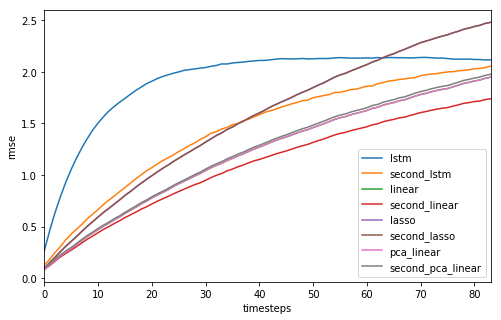

In [15]:
#Error metrics for Radio shop building
radioshop_errors, radioshop_mean, radioshop_sem, radioshop_sq = building("C:/Users/Aishu/Desktop/Project/Aishwarya/Data/hvac_zone_radioshop.pkl", "radioshop_lstm1b.pickle", "radioshop_lstm2b.pickle")

(14090, 1, 5) (14090,) (6039, 1, 5) (6039,)
(14090, 2, 5) (14090,) (6039, 2, 5) (6039,)


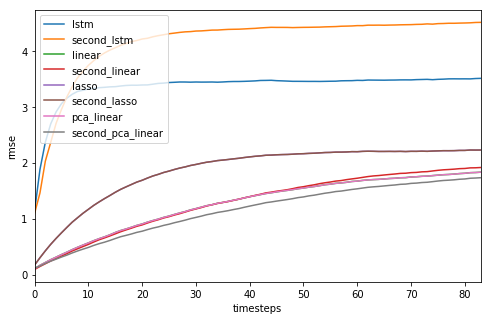

In [16]:
#Error metrics for electrical shop building
electricalshop_errors, electricalshop_mean, electricalshop_sem, electricalshop_sq = building("C:/Users/Aishu/Desktop/Project/Aishwarya/Data/hvac_zone_electricalshop.pkl", "electricalshop_lstm1b.pickle", "electricalshop_lstm2b.pickle")

(14207, 1, 5) (14207,) (6090, 1, 5) (6090,)
(14207, 2, 5) (14207,) (6090, 2, 5) (6090,)


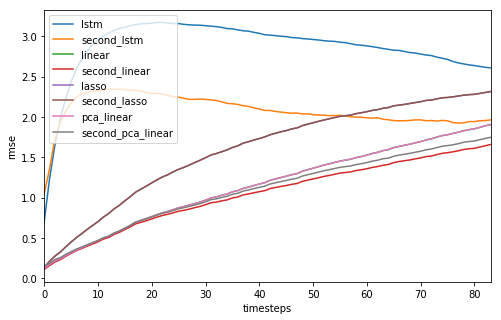

In [17]:
#Error metrics for FAC main department building
facmaindept_errors, facmaindept_mean, facmaindept_sem, facmaindept_sq = building("C:/Users/Aishu/Desktop/Project/Aishwarya/Data/hvac_zone_fac_main_dept.pkl", "facmaindept_lstm1b.pickle", "facmaindept_lstm2b.pickle")

In [18]:
def generalMetrics(methods, radioshop, electricalshop, facmaindept):
    ''' Calculates overall error metrics for above buildings and the RMSE values are plotted
        Parameters: list of methods , error metric values of all methods for each building
        Return: Combined error metric value for all buildings
    '''
    duration = 60*7

    generalBuilding = pd.DataFrame()
    for col in methods:
        a_mean = []
        a1 = np.array(radioshop[col])
        a2 = np.array(electricalshop[col])
        a3 = np.array(facmaindept[col])
        #Find the mean of errors of all the buildings
        for i in range(int(duration/5)):
            a = np.array([a1[i],a2[i],a3[i]])
            a_mean.append(np.mean(a))
        generalBuilding[col] = a_mean
    
    #Plot the generalised error of all buildings
    fig, ax = plt.subplots(figsize=(8,5))
    generalBuilding.plot(ax=ax)
    plt.xlabel('timesteps')
    plt.ylabel('rmse')
    plt.show()

    return generalBuilding

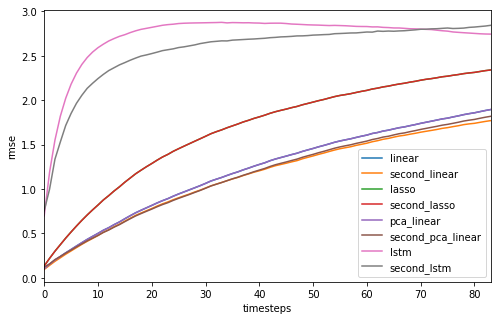

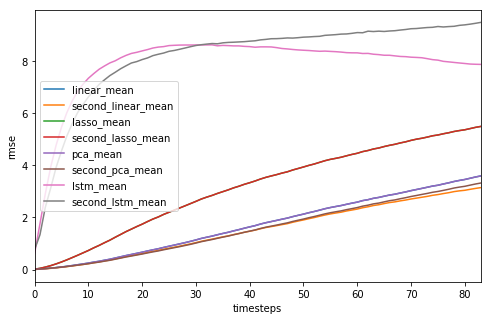

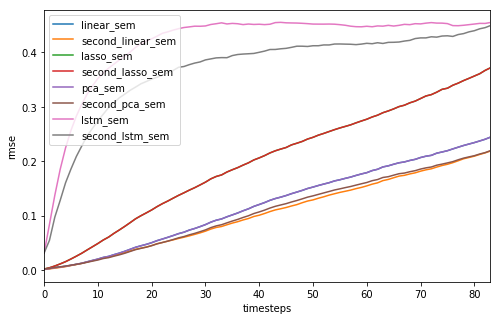

In [19]:
methods_errors = ['linear', 'second_linear', 'lasso', 'second_lasso', 'pca_linear', 'second_pca_linear', 'lstm', 'second_lstm']
methods_mean = ['linear_mean', 'second_linear_mean', 'lasso_mean', 'second_lasso_mean', 'pca_mean', 'second_pca_mean', 'lstm_mean', 'second_lstm_mean']
methods_sem = ['linear_sem', 'second_linear_sem', 'lasso_sem', 'second_lasso_sem', 'pca_sem', 'second_pca_sem', 'lstm_sem', 'second_lstm_sem']
#methods_sq = ['linear_sq', 'second_linear_sq', 'lasso_sq', 'second_lasso_sq', 'pca_sq', 'second_pca_sq', 'lstm_sq', 'second_lstm_sq']

generalErrors = generalMetrics(methods_errors, radioshop_errors, electricalshop_errors, facmaindept_errors)
generalMeans = generalMetrics(methods_mean, radioshop_mean, electricalshop_mean, facmaindept_mean)
generalSem = generalMetrics(methods_sem, radioshop_sem, electricalshop_sem, facmaindept_sem)
#generalSq = generalMetrics(methods_sq, radioshop_sq, electricalshop_sq, facmaindept_sq)


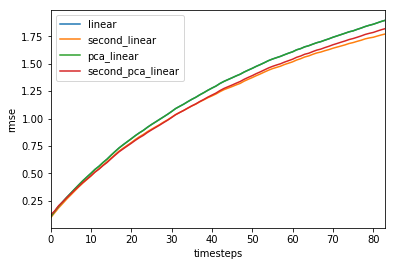

In [20]:
#Plot only the errors of regression model for a general building
test = generalErrors[['linear', 'second_linear','pca_linear', 'second_pca_linear']]
test.plot()
plt.xlabel('timesteps')
plt.ylabel('rmse')
plt.show()

# T-Test

It is a technique used to find the significance of the difference between the models. 

In [34]:
def timeStepErrors(errs):
    #Finds the squares of errors for each interval
    errors = []
    duration = 60*7
    for i in range(int(duration/5)):
            ei = np.array([])
            for e in errs:
                ei = np.append(ei, e.loc[i]*e.loc[i])
            errors.append(ei)
    return errors

In [28]:
def t_test(errs1, errs2):
    ''' Find the t and p value of squared errors of two methods and find the significance in their difference 
        Parameters: Squared errors of methods
        Return: p-values
    '''
    p_values = []
    #Get the squares of errors for each interval
    errors1 = timeStepErrors(errs1)
    errors2 = timeStepErrors(errs2)
    #Find the t and p values for each interval 
    for i in range(len(errors1)):
        t, p = stats.ttest_rel(errors1[i], errors2[i])
        p_values.append(p)
    return p_values

rs,ri = t_test(radioshop_sq['linear_sq'], radioshop_sq['second_linear_sq'])
es,ei = t_test(electricalshop_sq['linear_sq'], electricalshop_sq['second_linear_sq'])
fs,fi =(facmaindept_sq['linear_sq'], facmaindept_sq['second_linear_sq'])
s = np.array([rs,es,fs])
i = np.array([ri, ei, fi])
s_mean = np.mean(s)
i_mean = np.mean(i)




# Plotting Confidence Interval graphs for all buildings

In [35]:
def cigraphs(methods, building_mean, building_sem, building_sq, duration):
    ''' Plots confidence interval graphs for every pair of methods.
        Parametrs: List of methods, Mean Squared Error of the building, Standard Error Mean of the building
        Return: Plots the graph of confidence intreval
    '''
    
    for i in range(len(methods)):
        method1 = methods[i]
        for j in range(i+1, len(methods)):
            method2 = methods[j]
            p_values = t_test(building_sq[method1+'_sq'], building_sq[method2+'_sq'])
            print(p_values)
            plt.errorbar(x=range(len(building_mean[method1+'_mean'])), y=building_mean[method1+'_mean'], yerr=building_sem[method1+'_sem'], label=method1)
            plt.errorbar(x=range(len(building_mean[method2+'_mean'])), y=building_mean[method2+'_mean'], yerr=building_sem[method2+'_sem'], label = method2)
            #plt.errorbar(x=range(len(generalMeans['second_pca_mean'])), y=generalMeans['second_pca_mean'], yerr=generalSem['second_pca_sem'], label = 'second order linear with pca')
            plt.xlabel('timesteps')
            plt.ylabel('squared errors')
            plt.title(method1 + " versus " + method2)
            plt.legend()
            plt.show()

[0.74670380377642753, 0.073444949422267855, 0.019225187856569702, 0.010377014732377827, 0.0055900842035848447, 0.0040499215996680346, 0.00011588399446381729, 4.1968450082855577e-05, 3.8994813706112676e-05, 4.4379499472630522e-05, 4.2952146964722108e-05, 0.000132582971440399, 5.9924162674898906e-05, 4.5042311370203933e-05, 5.5463470557192442e-05, 3.901823907918938e-05, 1.0453910965639814e-05, 3.507832378998823e-06, 1.8245268823370513e-06, 7.8615610413524268e-07, 3.9316545367545027e-07, 5.4354223177530519e-07, 7.9626441847913964e-07, 5.4970169495767071e-07, 1.3184849021514294e-07, 4.8790121837068238e-08, 6.0955237129862173e-08, 4.0255915931138253e-08, 1.6879481144410974e-08, 6.0456972991247274e-09, 3.3972220675669619e-09, 4.327420698159795e-09, 1.0762390400211342e-08, 1.0036771005046292e-08, 1.5957729933234193e-08, 1.1863559278503877e-08, 1.6119550535722611e-08, 1.3475111813429392e-08, 1.0355958413065823e-08, 5.3719392380715317e-09, 2.3634807085017086e-09, 1.7673097093383497e-09, 8.57378

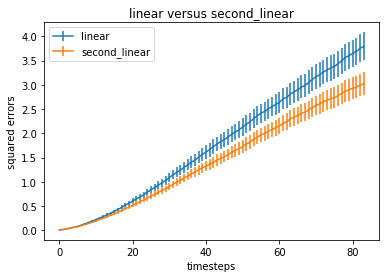

[3.6327379267800594e-09, 7.3404469571088986e-12, 2.0608026782328375e-10, 2.2054682445639099e-10, 5.5062369552304622e-12, 2.4632342926660024e-13, 1.6752874462238506e-12, 1.7055217539477504e-12, 1.2043232307847791e-12, 4.1907032557381236e-13, 2.1557565437394442e-13, 9.191104365462464e-14, 8.6476729012809312e-14, 5.7792213765124445e-14, 1.1424766154728027e-14, 4.2490295615162408e-15, 3.5720959088904077e-15, 1.6968495691936554e-15, 3.1178697924774354e-15, 1.6089762892448302e-15, 3.566239231828766e-15, 2.6444786411190384e-15, 1.9289490616798711e-15, 2.9474823297866406e-15, 6.9250091581167281e-15, 1.6435324689456318e-14, 1.4186648538847509e-14, 2.3081052240864081e-14, 4.4191695862299416e-14, 7.6148952570376356e-14, 9.6418874234332276e-14, 1.5558897688209561e-13, 9.0508064571669e-14, 1.193253316053663e-13, 1.3385083247538468e-13, 2.7638902515969502e-13, 2.4159317574344453e-13, 2.3900314902779045e-13, 3.7548834770755986e-13, 4.9400204434476738e-13, 7.9347447774687346e-13, 6.4220674234002024e-1

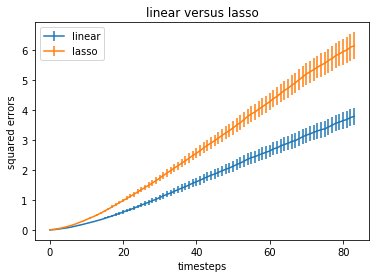

[3.6327379267800594e-09, 7.3404469571088986e-12, 2.0608026782328375e-10, 2.2054682445639099e-10, 5.5062369552304622e-12, 2.4632342926660024e-13, 1.6752874462238506e-12, 1.7055217539477504e-12, 1.2043232307847791e-12, 4.1907032557381236e-13, 2.1557565437394442e-13, 9.191104365462464e-14, 8.6476729012809312e-14, 5.7792213765124445e-14, 1.1424766154728027e-14, 4.2490295615162408e-15, 3.5720959088904077e-15, 1.6968495691936554e-15, 3.1178697924774354e-15, 1.6089762892448302e-15, 3.566239231828766e-15, 2.6444786411190384e-15, 1.9289490616798711e-15, 2.9474823297866406e-15, 6.9250091581167281e-15, 1.6435324689456318e-14, 1.4186648538847509e-14, 2.3081052240864081e-14, 4.4191695862299416e-14, 7.6148952570376356e-14, 9.6418874234332276e-14, 1.5558897688209561e-13, 9.0508064571669e-14, 1.193253316053663e-13, 1.3385083247538468e-13, 2.7638902515969502e-13, 2.4159317574344453e-13, 2.3900314902779045e-13, 3.7548834770755986e-13, 4.9400204434476738e-13, 7.9347447774687346e-13, 6.4220674234002024e-1

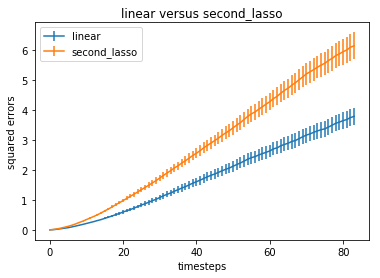

[0.021395686856042834, 0.001039512585639378, 0.0043456596190530545, 0.0094882970985599845, 0.00012613234963750966, 2.2212477455314651e-05, 1.2901267308481176e-05, 3.8289554054229456e-06, 3.1752285068694082e-07, 4.4048634409020421e-07, 1.0429848772268185e-07, 3.6242109136403935e-08, 1.8952000773641523e-08, 2.7702708257760944e-09, 4.3428256000571231e-10, 4.4203100182322865e-11, 9.6636141164278144e-12, 4.1817639437019292e-12, 1.2228289211588135e-12, 1.975815963584994e-12, 3.4081099759424605e-12, 3.6649652724316692e-12, 4.0841000292011424e-12, 1.4395594183931477e-11, 8.0029153923940804e-11, 2.3723145855229683e-10, 2.4331828192441975e-10, 1.5719396508752045e-10, 6.3455959417055153e-11, 8.7114511893149995e-11, 7.4931459468165501e-11, 4.1664662501475575e-11, 1.5364368769353337e-11, 2.4581773780367163e-11, 5.1863136628379449e-12, 1.0798032092299943e-11, 9.7906132926903644e-12, 8.7437881243063513e-12, 7.7730909237406846e-12, 1.9487492562284957e-11, 1.9054239846600699e-11, 1.5041946550484703e-11

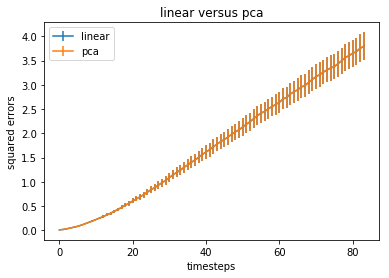

[1.7709490851311182e-08, 1.5845133759888811e-11, 8.3573589854614328e-12, 1.8921599798169341e-08, 8.6628551032521698e-08, 7.0105866969841077e-06, 1.7881945976043589e-05, 0.00034214469470954229, 0.00020313267478386498, 0.0012952041525664585, 0.0017873431060370399, 0.0025527791294882116, 0.0047606970407872446, 0.0039463386602642649, 0.0061575598154121561, 0.006795792815635332, 0.011692397703420255, 0.017067785048405566, 0.022943810167097158, 0.022821040229448367, 0.034213850450104284, 0.031970388752377878, 0.035415664006062227, 0.041206625387631063, 0.053190662759573341, 0.071667064197155086, 0.064607948922424011, 0.058780776739563119, 0.048100310752516841, 0.047261498485218684, 0.045113475431794038, 0.040102392855220874, 0.036641108737169019, 0.032839400943151839, 0.02535781449312275, 0.027536961807822759, 0.023926223073182575, 0.026211814231066621, 0.026854375691682451, 0.032567896920371472, 0.032077919238663238, 0.030783324437047562, 0.039406632508029851, 0.032856801212421807, 0.032679

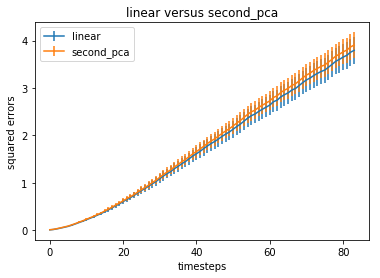

[3.7946417857750649e-16, 9.3309844837366004e-14, 1.6437919515687164e-13, 2.7514814369713348e-13, 3.9587203431674998e-13, 1.9704815317881142e-13, 1.210980375181063e-13, 8.5625108268839638e-14, 7.3409183944041244e-14, 4.9036595209999379e-14, 4.5832547924089954e-14, 3.7081168452379489e-14, 2.7732700609855058e-14, 2.8092737790103843e-14, 2.0334896638286142e-14, 2.2192945554408593e-14, 2.2579315821431537e-14, 2.2175691561728381e-14, 2.5948574089141497e-14, 2.6204394647942459e-14, 2.4934639199110454e-14, 3.1727797880712669e-14, 3.9747185385102636e-14, 4.2382392387030581e-14, 9.8961857552823009e-14, 1.2216820607390055e-13, 1.8624883432916082e-13, 2.898336431516801e-13, 3.9376620698616245e-13, 6.4943607265946748e-13, 8.4974027828915711e-13, 1.6200934723552283e-12, 1.9337377167401748e-12, 2.830763092425462e-12, 5.2641392714477761e-12, 7.9301206726435237e-12, 1.1054250611443383e-11, 1.6297713704897122e-11, 3.0039718344001216e-11, 4.5040186157461156e-11, 6.1247095038940075e-11, 1.1524578280009869

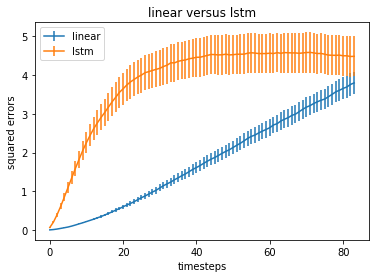

[5.1482996090182248e-06, 1.8732735066096492e-05, 1.810063531711076e-07, 8.3412207197324679e-08, 8.6052966480840551e-10, 2.5631733731509379e-11, 4.9353351438162183e-11, 4.267754294366441e-11, 4.8600567276943794e-11, 4.322527142134853e-11, 6.7522536884250937e-11, 2.4237588188956495e-11, 1.8690964093453169e-11, 6.1592936093931974e-11, 3.1581642247793029e-11, 1.0993259938970929e-10, 8.1837426772034626e-11, 3.8199567419167995e-11, 8.093669118303398e-11, 8.9683221391868258e-11, 1.9317707519613039e-10, 1.9597915850404095e-10, 2.579354817895224e-10, 7.9870363105090059e-10, 2.4913071896504188e-09, 4.7118711437338849e-09, 7.0787325634517749e-09, 1.0032324502078838e-08, 2.1423767992606176e-08, 1.5562185134844505e-08, 5.3975720761440688e-08, 5.6644696353734754e-08, 1.1232809687212716e-07, 8.3121233057141801e-08, 2.8617240058067766e-07, 4.4886828221558782e-07, 9.7877172351009602e-07, 9.7176611385582574e-07, 1.5096507502591283e-06, 2.4060528750167365e-06, 1.9968105474223335e-06, 2.3562429532778139e-

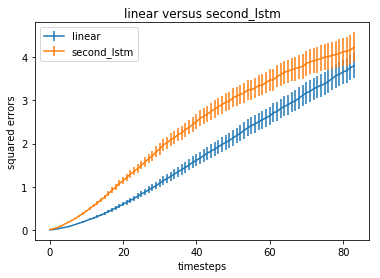

[1.5888705282349856e-08, 1.8202629417339893e-17, 2.0404259111303108e-18, 2.4862065682273565e-18, 5.2017422195979381e-21, 4.8200359533129351e-23, 1.9325013915888863e-23, 3.0294799798349332e-24, 2.6225988314285201e-24, 7.4153439507220917e-25, 4.6006107066745325e-25, 2.4622745672440525e-25, 2.307240867964279e-25, 1.8347712002155475e-25, 2.9293539665764166e-26, 6.187708772499227e-27, 2.1912218828660285e-27, 5.3771949526163568e-28, 9.9697738289272358e-28, 1.2325269554424207e-28, 2.3298304104833317e-28, 3.4327540501649187e-28, 2.6433785096314821e-28, 3.856271986779278e-28, 6.4589364786855406e-28, 1.5245246333020119e-27, 1.7381213853260324e-27, 2.5804217872960139e-27, 5.5594352747677211e-27, 6.7247823645851314e-27, 5.1256772273856125e-27, 9.2357676723915658e-27, 5.7554404453841472e-27, 8.6716183524141571e-27, 1.3244209079880355e-26, 2.5767873008712308e-26, 2.7872748503691965e-26, 2.3422251063161244e-26, 4.3634143085160728e-26, 4.6918368918679168e-26, 7.7013218088029523e-26, 4.2480227192773006

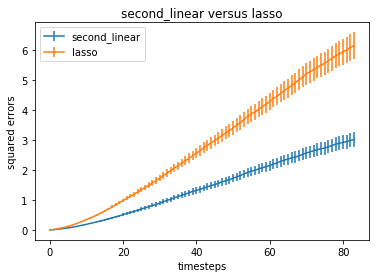

[1.5888705282349856e-08, 1.8202629417339893e-17, 2.0404259111303108e-18, 2.4862065682273565e-18, 5.2017422195979381e-21, 4.8200359533129351e-23, 1.9325013915888863e-23, 3.0294799798349332e-24, 2.6225988314285201e-24, 7.4153439507220917e-25, 4.6006107066745325e-25, 2.4622745672440525e-25, 2.307240867964279e-25, 1.8347712002155475e-25, 2.9293539665764166e-26, 6.187708772499227e-27, 2.1912218828660285e-27, 5.3771949526163568e-28, 9.9697738289272358e-28, 1.2325269554424207e-28, 2.3298304104833317e-28, 3.4327540501649187e-28, 2.6433785096314821e-28, 3.856271986779278e-28, 6.4589364786855406e-28, 1.5245246333020119e-27, 1.7381213853260324e-27, 2.5804217872960139e-27, 5.5594352747677211e-27, 6.7247823645851314e-27, 5.1256772273856125e-27, 9.2357676723915658e-27, 5.7554404453841472e-27, 8.6716183524141571e-27, 1.3244209079880355e-26, 2.5767873008712308e-26, 2.7872748503691965e-26, 2.3422251063161244e-26, 4.3634143085160728e-26, 4.6918368918679168e-26, 7.7013218088029523e-26, 4.2480227192773006

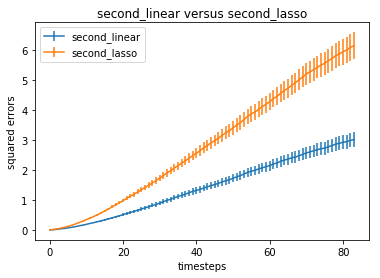

[0.74670380377713919, 0.073444949422485056, 0.019225187856640666, 0.010377014732419537, 0.0055900842036177793, 0.0040499215996958595, 0.00011588399446497153, 4.1968450083341421e-05, 3.8994813706597646e-05, 4.4379499473172847e-05, 4.2952146965263965e-05, 0.00013258297144202346, 5.9924162675685576e-05, 4.5042311370823852e-05, 5.5463470557949682e-05, 3.9018239079731894e-05, 1.0453910965798068e-05, 3.5078323790556602e-06, 1.8245268823678545e-06, 7.8615610414897668e-07, 3.9316545368239197e-07, 5.4354223178494305e-07, 7.9626441849264685e-07, 5.4970169496694085e-07, 1.3184849021741613e-07, 4.8790121837899594e-08, 6.0955237130897711e-08, 4.0255915931828373e-08, 1.6879481144711413e-08, 6.0456972992334562e-09, 3.3972220676279577e-09, 4.3274206982375682e-09, 1.0762390400398022e-08, 1.0036771005218645e-08, 1.5957729933507268e-08, 1.1863559278702622e-08, 1.6119550535988248e-08, 1.347511181365173e-08, 1.035595841323776e-08, 5.3719392381606902e-09, 2.3634807085410365e-09, 1.7673097093677335e-09, 8.57

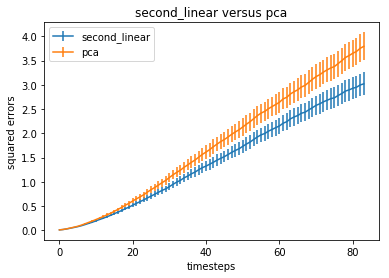

[6.4273626648677037e-06, 9.0566788212117195e-06, 2.0025616935457828e-07, 1.7178995187144459e-06, 3.5738027996508313e-07, 1.0314207147288517e-06, 1.0585093431877369e-08, 1.1119002614175796e-08, 4.3563194888206809e-09, 1.2147750372710799e-08, 1.1691362388244739e-08, 4.7575960229610551e-08, 2.9651859882013076e-08, 1.9185108850367912e-08, 4.9570196190781661e-08, 3.1247358360839923e-08, 8.1455286103112274e-09, 2.2654933030459785e-09, 1.2754848254130099e-09, 3.0735807975563683e-10, 1.7964354581610082e-10, 1.8862684720852819e-10, 3.5409383092883285e-10, 1.712792035820594e-10, 4.7359918925402051e-11, 2.7000027908866326e-11, 3.7558359570009973e-11, 2.2601264178190828e-11, 8.1857377763325352e-12, 2.7269086811381569e-12, 1.1281448371335675e-12, 1.5089213424879114e-12, 4.1504370198757447e-12, 4.4121124644597525e-12, 5.9004260488221125e-12, 5.7195399223406653e-12, 8.1276744138806807e-12, 6.372664078316762e-12, 5.3689732973816117e-12, 3.1011076804004932e-12, 1.3936243553742788e-12, 1.006537408211834

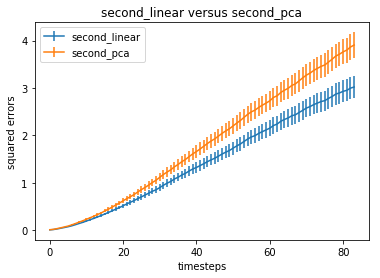

[4.1814463959595755e-16, 7.9391676213596779e-14, 1.299555076670169e-13, 2.1580018684791928e-13, 3.0890633918173311e-13, 1.52912372007125e-13, 8.2406241892801004e-14, 5.4221650034816074e-14, 4.4940587721141138e-14, 2.9209771009680112e-14, 2.6688952669136423e-14, 2.2210038398861283e-14, 1.5371570910336946e-14, 1.4748045806574829e-14, 1.0339541243801458e-14, 1.0594597921566838e-14, 9.7383407877159008e-15, 8.8561060453898166e-15, 9.6150842091293966e-15, 8.8561587323493226e-15, 7.404945925222221e-15, 9.125073180390016e-15, 1.0804740802769964e-14, 1.055288505841399e-14, 2.061907400527618e-14, 2.12576871583395e-14, 3.0080086478113575e-14, 4.0114987360382065e-14, 4.4603014491705497e-14, 5.9398267454649918e-14, 6.4056132164034345e-14, 1.1090828287930334e-13, 1.2724222273272694e-13, 1.6784588662100563e-13, 2.7713745230816441e-13, 3.5179531098466948e-13, 4.3503013501676482e-13, 5.5843353587324966e-13, 9.1235173014744583e-13, 1.0913473059289677e-12, 1.2271905896112883e-12, 2.0025175409374848e-12, 

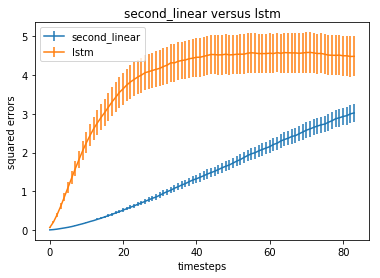

[3.2541306169192976e-06, 5.7719674820991515e-06, 1.3858918307606783e-08, 5.3570904123660303e-09, 3.7604061055623944e-11, 6.6153854778527066e-13, 3.4762720359168315e-13, 1.667813429990529e-13, 1.5813176977911665e-13, 8.478859153419278e-14, 1.3704497214739486e-13, 6.6192835678764165e-14, 3.5693542354717368e-14, 1.249959027243116e-13, 5.4946572175486236e-14, 1.4222981025411955e-13, 5.4911086518311121e-14, 1.5200828641562743e-14, 2.7217551540311984e-14, 2.979968257530684e-14, 4.9927680718395744e-14, 5.6676712858277847e-14, 6.8796475103625682e-14, 2.1317979605025972e-13, 5.0956591280565634e-13, 5.9505810257680645e-13, 1.1156854139253688e-12, 1.3857706329567216e-12, 2.1150798791226393e-12, 9.4309205300723263e-13, 3.2738499434603119e-12, 3.3900886887453396e-12, 4.515234612600001e-12, 2.2789615361931442e-12, 8.9315300027506401e-12, 1.4752248577441722e-11, 2.6303410559724602e-11, 2.1373045091021284e-11, 2.2211074257054324e-11, 2.6374972079355665e-11, 1.0764590602518754e-11, 1.2263325498379036e-

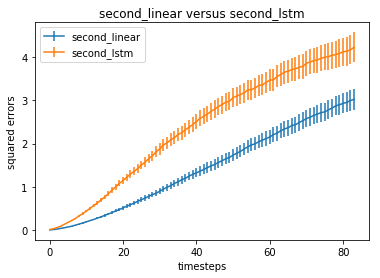

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


C:\Users\Aishu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Aishu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Aishu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


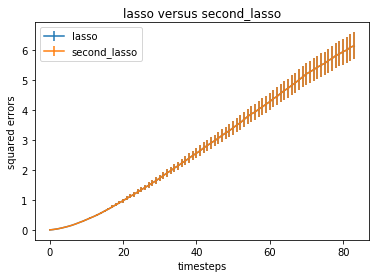

[3.6327379267796214e-09, 7.340446957098331e-12, 2.0608026782316603e-10, 2.2054682445640384e-10, 5.5062369552231169e-12, 2.4632342926617791e-13, 1.6752874462208044e-12, 1.7055217539442181e-12, 1.2043232307814611e-12, 4.1907032557256598e-13, 2.1557565437321228e-13, 9.1911043654296411e-14, 8.6476729012462377e-14, 5.7792213764866935e-14, 1.1424766154671474e-14, 4.2490295614934711e-15, 3.5720959088687511e-15, 1.6968495691832986e-15, 3.117869792457928e-15, 1.6089762892349405e-15, 3.5662392318074676e-15, 2.6444786411032194e-15, 1.9289490616685695e-15, 2.9474823297701669e-15, 6.9250091580800564e-15, 1.643532468937049e-14, 1.4186648538773231e-14, 2.3081052240737444e-14, 4.4191695862051764e-14, 7.6148952569950018e-14, 9.6418874233803878e-14, 1.5558897688122019e-13, 9.0508064571146534e-14, 1.1932533160468775e-13, 1.3385083247459443e-13, 2.7638902515808347e-13, 2.4159317574203513e-13, 2.3900314902638226e-13, 3.75488347705351e-13, 4.9400204434191799e-13, 7.9347447774242191e-13, 6.4220674233633873e-

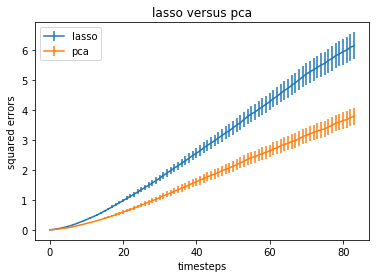

[0.019342814623448328, 4.651504124095632e-05, 0.00074446942742153576, 1.2138163543621165e-06, 1.9291709502388269e-08, 1.5896340378040321e-10, 4.1885540348679042e-10, 9.5383359691328713e-11, 5.4828747196165695e-11, 1.0696420618758286e-11, 4.524173802389467e-12, 1.3543975814562269e-12, 1.0732170490995728e-12, 8.5794058181207287e-13, 1.7424322477248572e-13, 7.23205595397993e-14, 5.7291982126444102e-14, 2.410853556497916e-14, 4.6065692791376903e-14, 2.2544708907972726e-14, 4.388909527782787e-14, 3.7947000715220767e-14, 2.8567166664395496e-14, 4.2119277996448749e-14, 9.3853463815390323e-14, 2.2717389815319696e-13, 2.175175850548851e-13, 4.0677064500664655e-13, 8.7598279714981699e-13, 1.5795870154634725e-12, 1.9603835228476976e-12, 3.4549263976175248e-12, 2.3029502393040875e-12, 3.2887743264211104e-12, 4.1614929221254738e-12, 8.487358565223839e-12, 8.1519767163783711e-12, 8.2686306968305756e-12, 1.2751265935435023e-11, 1.6018429824952292e-11, 2.5119537342336025e-11, 2.1726607645837476e-11, 2

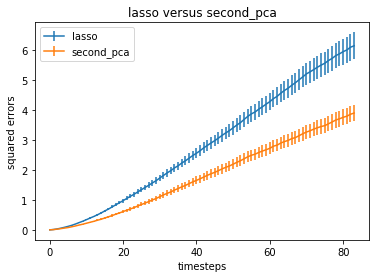

[3.1402336480468801e-15, 5.0709028094259403e-13, 6.937674383397808e-13, 1.2556487368751191e-12, 2.2534745754508586e-12, 1.3977744049522618e-12, 9.0606702392125237e-13, 7.624108477875796e-13, 8.1601415847206355e-13, 6.6552341819982112e-13, 8.0394222100199e-13, 8.9650809563646232e-13, 8.496849105067955e-13, 1.1001531446789823e-12, 1.2371596299336173e-12, 1.8703863555362096e-12, 2.3065769632894731e-12, 3.3457755557263054e-12, 4.9058884981808228e-12, 6.8547545146447657e-12, 8.3783479649332731e-12, 1.4536132553105854e-11, 2.6233245565080275e-11, 3.5615914199621974e-11, 9.556770265237427e-11, 1.5187713549100299e-10, 3.1404382050493735e-10, 6.0576593871263159e-10, 1.1628398085017241e-09, 2.422885746285069e-09, 4.6321969200859897e-09, 1.0626098242097491e-08, 2.0320823691559388e-08, 3.6291835913425463e-08, 9.6853772454188498e-08, 1.646146193768095e-07, 3.6224419401504279e-07, 6.8696880247206328e-07, 1.5151004535862554e-06, 3.1795614604139289e-06, 5.6389775874740842e-06, 1.3016700421314807e-05, 

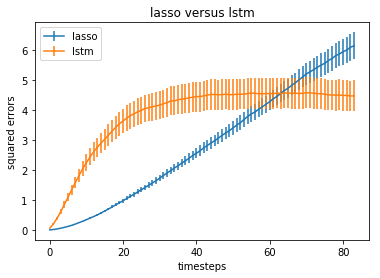

[0.00054220875197248859, 0.0085685724903206053, 0.00069662291513329232, 0.0021777732103003059, 0.00047364181500299582, 0.00021434178589897448, 0.00049562868309298454, 0.0014350484279610958, 0.0021325952817526205, 0.0028134675813107661, 0.0053905048172320806, 0.0047678588622831813, 0.0048861508309387749, 0.0089525935970517345, 0.010148895047571615, 0.019761022789332262, 0.017210125601623463, 0.017993502393411763, 0.023618503276199028, 0.026976019104577458, 0.039430923863851594, 0.048032474306891372, 0.061370087072337723, 0.088573815658246707, 0.12973339352659677, 0.13706288749965229, 0.17332171480829425, 0.16966089160846221, 0.2405180810541922, 0.1949567900068683, 0.29023982234809292, 0.27612722467617395, 0.43258021998033169, 0.45052286875295322, 0.68076582150911336, 0.66948107796236922, 0.95924616222564263, 0.95638489369384261, 0.86920069375003139, 0.76436204643647443, 0.73284367232919134, 0.69106753720824909, 0.4917625636331644, 0.40157193947590086, 0.35654401905621302, 0.305548459024

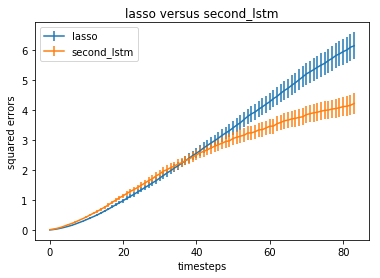

[3.6327379267796214e-09, 7.340446957098331e-12, 2.0608026782316603e-10, 2.2054682445640384e-10, 5.5062369552231169e-12, 2.4632342926617791e-13, 1.6752874462208044e-12, 1.7055217539442181e-12, 1.2043232307814611e-12, 4.1907032557256598e-13, 2.1557565437321228e-13, 9.1911043654296411e-14, 8.6476729012462377e-14, 5.7792213764866935e-14, 1.1424766154671474e-14, 4.2490295614934711e-15, 3.5720959088687511e-15, 1.6968495691832986e-15, 3.117869792457928e-15, 1.6089762892349405e-15, 3.5662392318074676e-15, 2.6444786411032194e-15, 1.9289490616685695e-15, 2.9474823297701669e-15, 6.9250091580800564e-15, 1.643532468937049e-14, 1.4186648538773231e-14, 2.3081052240737444e-14, 4.4191695862051764e-14, 7.6148952569950018e-14, 9.6418874233803878e-14, 1.5558897688122019e-13, 9.0508064571146534e-14, 1.1932533160468775e-13, 1.3385083247459443e-13, 2.7638902515808347e-13, 2.4159317574203513e-13, 2.3900314902638226e-13, 3.75488347705351e-13, 4.9400204434191799e-13, 7.9347447774242191e-13, 6.4220674233633873e-

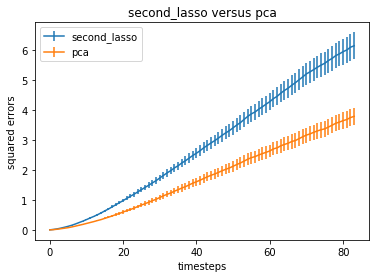

[0.019342814623448328, 4.651504124095632e-05, 0.00074446942742153576, 1.2138163543621165e-06, 1.9291709502388269e-08, 1.5896340378040321e-10, 4.1885540348679042e-10, 9.5383359691328713e-11, 5.4828747196165695e-11, 1.0696420618758286e-11, 4.524173802389467e-12, 1.3543975814562269e-12, 1.0732170490995728e-12, 8.5794058181207287e-13, 1.7424322477248572e-13, 7.23205595397993e-14, 5.7291982126444102e-14, 2.410853556497916e-14, 4.6065692791376903e-14, 2.2544708907972726e-14, 4.388909527782787e-14, 3.7947000715220767e-14, 2.8567166664395496e-14, 4.2119277996448749e-14, 9.3853463815390323e-14, 2.2717389815319696e-13, 2.175175850548851e-13, 4.0677064500664655e-13, 8.7598279714981699e-13, 1.5795870154634725e-12, 1.9603835228476976e-12, 3.4549263976175248e-12, 2.3029502393040875e-12, 3.2887743264211104e-12, 4.1614929221254738e-12, 8.487358565223839e-12, 8.1519767163783711e-12, 8.2686306968305756e-12, 1.2751265935435023e-11, 1.6018429824952292e-11, 2.5119537342336025e-11, 2.1726607645837476e-11, 2

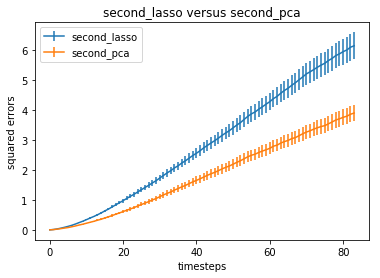

[3.1402336480468801e-15, 5.0709028094259403e-13, 6.937674383397808e-13, 1.2556487368751191e-12, 2.2534745754508586e-12, 1.3977744049522618e-12, 9.0606702392125237e-13, 7.624108477875796e-13, 8.1601415847206355e-13, 6.6552341819982112e-13, 8.0394222100199e-13, 8.9650809563646232e-13, 8.496849105067955e-13, 1.1001531446789823e-12, 1.2371596299336173e-12, 1.8703863555362096e-12, 2.3065769632894731e-12, 3.3457755557263054e-12, 4.9058884981808228e-12, 6.8547545146447657e-12, 8.3783479649332731e-12, 1.4536132553105854e-11, 2.6233245565080275e-11, 3.5615914199621974e-11, 9.556770265237427e-11, 1.5187713549100299e-10, 3.1404382050493735e-10, 6.0576593871263159e-10, 1.1628398085017241e-09, 2.422885746285069e-09, 4.6321969200859897e-09, 1.0626098242097491e-08, 2.0320823691559388e-08, 3.6291835913425463e-08, 9.6853772454188498e-08, 1.646146193768095e-07, 3.6224419401504279e-07, 6.8696880247206328e-07, 1.5151004535862554e-06, 3.1795614604139289e-06, 5.6389775874740842e-06, 1.3016700421314807e-05, 

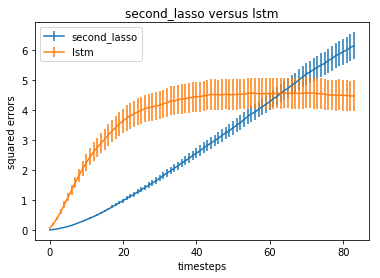

[0.00054220875197248859, 0.0085685724903206053, 0.00069662291513329232, 0.0021777732103003059, 0.00047364181500299582, 0.00021434178589897448, 0.00049562868309298454, 0.0014350484279610958, 0.0021325952817526205, 0.0028134675813107661, 0.0053905048172320806, 0.0047678588622831813, 0.0048861508309387749, 0.0089525935970517345, 0.010148895047571615, 0.019761022789332262, 0.017210125601623463, 0.017993502393411763, 0.023618503276199028, 0.026976019104577458, 0.039430923863851594, 0.048032474306891372, 0.061370087072337723, 0.088573815658246707, 0.12973339352659677, 0.13706288749965229, 0.17332171480829425, 0.16966089160846221, 0.2405180810541922, 0.1949567900068683, 0.29023982234809292, 0.27612722467617395, 0.43258021998033169, 0.45052286875295322, 0.68076582150911336, 0.66948107796236922, 0.95924616222564263, 0.95638489369384261, 0.86920069375003139, 0.76436204643647443, 0.73284367232919134, 0.69106753720824909, 0.4917625636331644, 0.40157193947590086, 0.35654401905621302, 0.305548459024

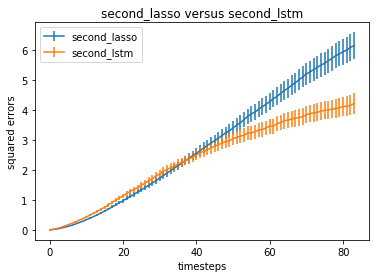

[1.7709490851294718e-08, 1.5845133759754294e-11, 8.3573589854234892e-12, 1.8921599798121807e-08, 8.6628551032025138e-08, 7.01058669692644e-06, 1.7881945975878956e-05, 0.00034214469470587107, 0.00020313267478113252, 0.0012952041525500849, 0.0017873431060122841, 0.0025527791294515162, 0.0047606970407167862, 0.0039463386602023153, 0.0061575598153131616, 0.0067957928155227467, 0.011692397703226984, 0.01706778504813028, 0.022943810166729979, 0.022821040229092027, 0.034213850449610367, 0.0319703887519193, 0.035415664005576872, 0.04120662538709826, 0.053190662758937926, 0.071667064196361971, 0.064607948921701672, 0.058780776738898782, 0.048100310751950474, 0.047261498484668291, 0.045113475431272497, 0.040102392854748196, 0.036641108736730092, 0.032839400942761651, 0.025357814492804946, 0.02753696180749142, 0.023926223072893101, 0.026211814230754884, 0.026854375691367709, 0.032567896920009158, 0.03207791923831245, 0.03078332443670824, 0.039406632507625036, 0.032856801212080143, 0.0326796070869

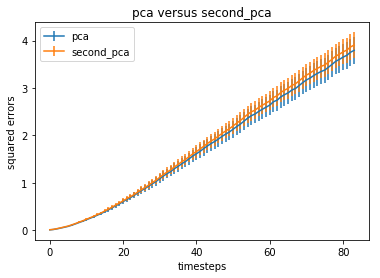

[3.7946417857741892e-16, 9.3309844837357901e-14, 1.6437919515686094e-13, 2.7514814369711556e-13, 3.9587203431670126e-13, 1.9704815317878363e-13, 1.2109803751808701e-13, 8.5625108268825073e-14, 7.3409183944025846e-14, 4.9036595209988045e-14, 4.5832547924078039e-14, 3.7081168452367966e-14, 2.7732700609845847e-14, 2.8092737790092881e-14, 2.0334896638277398e-14, 2.2192945554397375e-14, 2.2579315821419221e-14, 2.2175691561715409e-14, 2.5948574089125654e-14, 2.6204394647925139e-14, 2.4934639199092711e-14, 3.1727797880688379e-14, 3.9747185385069327e-14, 4.2382392386993839e-14, 9.8961857552734669e-14, 1.2216820607378836e-13, 1.8624883432897694e-13, 2.8983364315137501e-13, 3.9376620698569802e-13, 6.4943607265866605e-13, 8.4974027828805296e-13, 1.6200934723529754e-12, 1.9337377167372958e-12, 2.8307630924211036e-12, 5.2641392714390172e-12, 7.9301206726301208e-12, 1.1054250611423658e-11, 1.6297713704866962e-11, 3.003971834394407e-11, 4.5040186157372014e-11, 6.1247095038816606e-11, 1.15245782799859

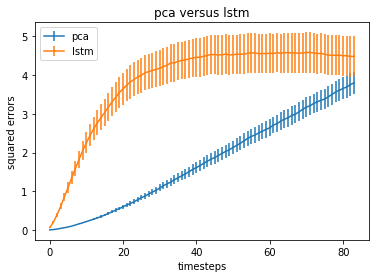

[5.1482996090145792e-06, 1.8732735066080452e-05, 1.8100635317091702e-07, 8.34122071972125e-08, 8.6052966480639908e-10, 2.5631733731430584e-11, 4.9353351437998175e-11, 4.2677542943493623e-11, 4.8600567276735345e-11, 4.3225271421159713e-11, 6.7522536883944803e-11, 2.4237588188840376e-11, 1.8690964093359445e-11, 6.1592936093625684e-11, 3.1581642247630805e-11, 1.0993259938916228e-10, 8.183742677161447e-11, 3.8199567418968276e-11, 8.0936691182615801e-11, 8.9683221391413322e-11, 1.9317707519516727e-10, 1.9597915850306454e-10, 2.5793548178826415e-10, 7.9870363104723483e-10, 2.4913071896393776e-09, 4.7118711437141889e-09, 7.0787325634219335e-09, 1.0032324502037178e-08, 2.1423767992516208e-08, 1.556218513477884e-08, 5.3975720761222544e-08, 5.6644696353506909e-08, 1.1232809687168055e-07, 8.3121233056805251e-08, 2.8617240057952904e-07, 4.4886828221387691e-07, 9.7877172350640804e-07, 9.7176611385220552e-07, 1.5096507502534875e-06, 2.4060528750081035e-06, 1.996810547415088e-06, 2.3562429532692521e-

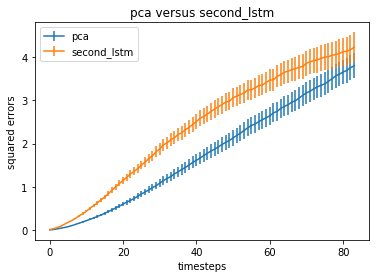

[1.3815404604091691e-14, 1.9723852354034447e-13, 3.6136616056553344e-13, 4.745185854623719e-13, 6.7481695548508846e-13, 3.2045476016708025e-13, 1.9963104099723822e-13, 1.3841434901481388e-13, 1.2306343868883345e-13, 8.2195282362952501e-14, 7.8936354984869757e-14, 6.638120287558955e-14, 5.091366883129924e-14, 5.4434679975253564e-14, 4.1486819419651907e-14, 4.8162116959951113e-14, 5.1031674016080286e-14, 5.2494769615551628e-14, 6.4078626313666682e-14, 6.7857914787046889e-14, 6.8441117794037856e-14, 9.1502666613713767e-14, 1.2058515700649938e-13, 1.3517725648653439e-13, 3.1857962647822434e-13, 4.0931522422629147e-13, 6.5416888434484758e-13, 1.0713244871723717e-12, 1.5991448064452509e-12, 2.7470529018796804e-12, 3.9451784192767384e-12, 7.9227744432035019e-12, 1.0355857906032976e-11, 1.5793676044666962e-11, 3.2125297507870171e-11, 4.9976550910361918e-11, 7.6040529940492574e-11, 1.18329549475417e-10, 2.2565533730314581e-10, 3.5495639386599933e-10, 5.1831607566273681e-10, 1.0067883063477622e-

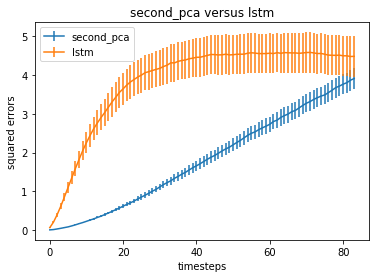

[0.014826581325352259, 0.00032116634094929506, 1.6283416507915661e-05, 1.9297212997736458e-06, 2.9259306111623126e-08, 7.4689607788060775e-10, 1.3639611507161472e-09, 7.9506906711858718e-10, 7.9097817237404187e-10, 5.2162045228345012e-10, 7.0506726464414963e-10, 2.5197728466502023e-10, 1.7308333947429058e-10, 5.3640774880131564e-10, 2.4408766087435245e-10, 7.030203995971849e-10, 4.4337327189473606e-10, 1.9877517808040625e-10, 3.7786723597078335e-10, 4.3983572889426901e-10, 8.4682612142001087e-10, 9.4909666797822088e-10, 1.2077631617066117e-09, 3.3954835307131705e-09, 1.0453381081072152e-08, 1.7272693096157764e-08, 2.8791616092214741e-08, 4.0937631800061606e-08, 9.0478832948906988e-08, 6.8295500927973316e-08, 2.2390708883208715e-07, 2.4271324707398219e-07, 4.7770661662633752e-07, 3.9688236306978142e-07, 1.3433290627053515e-06, 1.9769262047750176e-06, 4.4002374917757962e-06, 4.1856420342787255e-06, 6.7625697438624357e-06, 1.0043423139979127e-05, 8.8391708941460392e-06, 1.0598866837117837

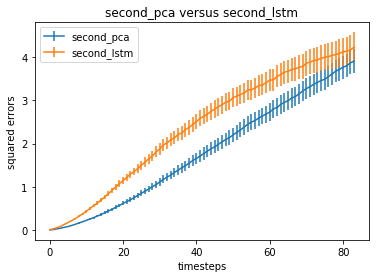

[6.3320679195859225e-12, 1.5330605389051193e-11, 1.7279189206004567e-11, 2.5985401237292831e-11, 6.1100735305573642e-11, 4.458787376388179e-11, 2.5417010428230531e-11, 1.964024596683258e-11, 2.5728890939374199e-11, 2.0839398865891335e-11, 2.453898772773661e-11, 3.3809925011859029e-11, 3.8190147817147138e-11, 4.8039453993195649e-11, 7.060726123946715e-11, 1.1374455213272347e-10, 1.8045908468939192e-10, 2.9614492287055766e-10, 4.7986105760000783e-10, 7.4463938687117341e-10, 9.9343976217482368e-10, 1.4825706973280803e-09, 2.5832470862001087e-09, 3.5422569712751813e-09, 7.1171494214756425e-09, 1.3140350355164331e-08, 2.0118536432985002e-08, 3.8153639089916458e-08, 6.2703956575823787e-08, 1.5685703553141818e-07, 2.5148977014600322e-07, 5.520947799156731e-07, 6.2344842267082959e-07, 8.3731786312166719e-07, 1.3672913752317298e-06, 2.4123273195257168e-06, 2.6336765632064623e-06, 5.1941336100471887e-06, 6.4018089770976944e-06, 1.0308164168919632e-05, 1.5661404826437805e-05, 2.9764288431915008e-

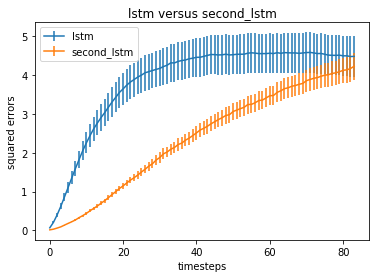

In [36]:
methods = ['linear', 'second_linear', 'lasso', 'second_lasso', 'pca', 'second_pca', 'lstm', 'second_lstm']
cigraphs(methods, radioshop_mean, radioshop_sem, radioshop_sq, 60*7)

[0.0074215200419147738, 0.0014338709240232464, 0.0056445589703187742, 0.0047007414588895562, 0.0078606430594485646, 0.0073954658776198617, 0.02561232521405734, 0.062152029746948022, 0.057531010397068746, 0.066031271041675596, 0.0884941385895779, 0.1555335528438338, 0.27490968621125861, 0.3248752396820842, 0.31484528562097791, 0.24850501044288806, 0.32377150160304169, 0.45965554842302581, 0.49493635305871297, 0.51990077590456218, 0.50875496694794131, 0.56729380497450843, 0.650206966725841, 0.68539817496891764, 0.71833906771371936, 0.71372847103917758, 0.72314668485277678, 0.67554984408661711, 0.80425109560418939, 0.80103634137756063, 0.84835647281182236, 0.81544315634478637, 0.87807991630208426, 0.98386539785127414, 0.91322619148118189, 0.97108430925347411, 0.94323392450105037, 0.92967420106721488, 0.9989864729425908, 0.97596100350210491, 0.99032726983008978, 0.90744803424594922, 0.87946350475651802, 0.77779606422311842, 0.78867563511165595, 0.77756554139406808, 0.79742942806658357, 0.7

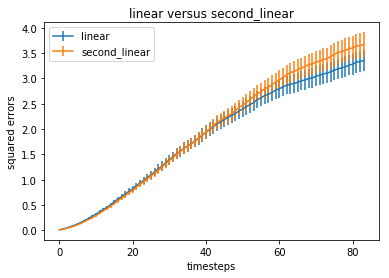

[9.5808628265150905e-32, 1.5808855270864962e-36, 2.3262694222256769e-37, 5.7383738079205253e-37, 1.054046312635692e-37, 1.0449643667732077e-37, 3.5385226089982017e-38, 4.3548432960927186e-39, 5.8417342645508772e-39, 2.0786652725254143e-39, 2.7936799888317108e-39, 1.1383181712622576e-39, 5.6197319601745035e-40, 7.9265587045621621e-40, 8.1765732606675963e-40, 4.5396606472281191e-40, 2.8220558122512049e-40, 1.1602667626133953e-40, 1.0186884149914679e-40, 6.2861628919398929e-41, 5.6678187915631881e-41, 3.0023665615814262e-41, 1.5757639523376328e-41, 8.0975734598277114e-42, 6.6409478360742715e-42, 3.450833103680426e-42, 2.8921883767308414e-42, 2.5067406305290643e-42, 1.3625012192306491e-42, 1.2710707515585739e-42, 9.2068486623883672e-43, 6.3649134435205757e-43, 3.4862320547297349e-43, 1.0585478905659986e-43, 9.8801841181988602e-44, 4.7357744525646066e-44, 3.0045334540543881e-44, 2.1995234510158098e-44, 8.9037047729239753e-45, 7.1226867140403077e-45, 3.745821135062207e-45, 1.5953053470048195

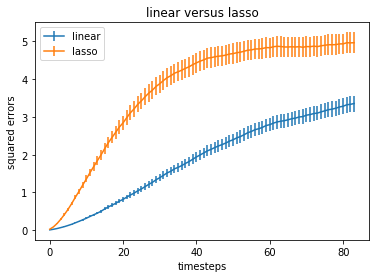

[9.5808628265150905e-32, 1.5808855270864962e-36, 2.3262694222256769e-37, 5.7383738079205253e-37, 1.054046312635692e-37, 1.0449643667732077e-37, 3.5385226089982017e-38, 4.3548432960927186e-39, 5.8417342645508772e-39, 2.0786652725254143e-39, 2.7936799888317108e-39, 1.1383181712622576e-39, 5.6197319601745035e-40, 7.9265587045621621e-40, 8.1765732606675963e-40, 4.5396606472281191e-40, 2.8220558122512049e-40, 1.1602667626133953e-40, 1.0186884149914679e-40, 6.2861628919398929e-41, 5.6678187915631881e-41, 3.0023665615814262e-41, 1.5757639523376328e-41, 8.0975734598277114e-42, 6.6409478360742715e-42, 3.450833103680426e-42, 2.8921883767308414e-42, 2.5067406305290643e-42, 1.3625012192306491e-42, 1.2710707515585739e-42, 9.2068486623883672e-43, 6.3649134435205757e-43, 3.4862320547297349e-43, 1.0585478905659986e-43, 9.8801841181988602e-44, 4.7357744525646066e-44, 3.0045334540543881e-44, 2.1995234510158098e-44, 8.9037047729239753e-45, 7.1226867140403077e-45, 3.745821135062207e-45, 1.5953053470048195

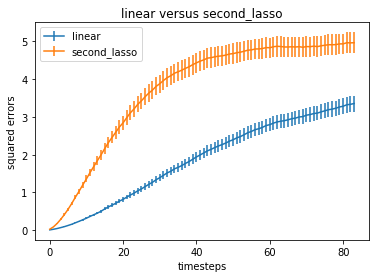

[1.6594734891695567e-08, 4.7039900030996389e-12, 2.1417290752071919e-15, 1.586440223300563e-15, 5.3934051874185048e-16, 7.0069049638143878e-17, 1.1262077287894253e-19, 7.142047003031113e-22, 1.0574314216892318e-21, 2.749292893692104e-23, 6.0526012057453026e-23, 1.2920450169340091e-24, 2.0872430232837583e-24, 7.5058778907020162e-25, 1.4120813725533514e-24, 3.0178464946695224e-24, 2.1941536177942907e-25, 2.8837148270426348e-26, 8.8131065140223773e-27, 1.4943257102000439e-27, 8.3243818210389944e-28, 1.480684211494853e-28, 4.3776295124718325e-30, 1.1488091757450008e-30, 6.0882760906474898e-31, 2.7164157120410215e-31, 8.7155060827035803e-32, 4.8151589356208752e-32, 1.9999193292135475e-32, 1.9344182513641439e-32, 3.1253827637504371e-32, 3.3675339549667356e-32, 1.2443756228668444e-32, 5.7243166292817193e-33, 3.0353972761347086e-33, 3.7669197258586078e-34, 1.7872497345708758e-34, 2.0432433602829035e-34, 7.1652315213866856e-35, 7.1926278365056362e-35, 6.2433075482482066e-35, 1.4946476637945864e

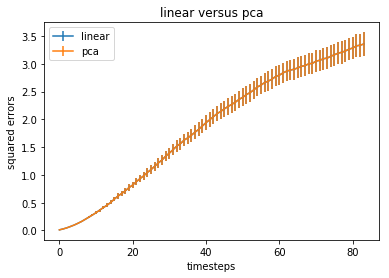

[0.082468791729227192, 0.0075750357341951681, 0.0053578464377033383, 6.7944593453385912e-07, 1.1932410776869598e-09, 1.3367527494222062e-12, 1.6441636511954255e-13, 2.3444949088304031e-14, 1.3302212956337342e-14, 3.6593535925435967e-15, 1.860585957914059e-15, 2.9018492894296742e-15, 6.6316962402854193e-15, 4.8989045078994172e-15, 4.1675367511333766e-15, 8.9781847227848188e-16, 2.9381597687930488e-15, 3.7988357027925361e-15, 4.4268081719127275e-15, 2.670941034044309e-15, 1.3754763982299019e-15, 1.5681584694105766e-15, 4.9402692118238687e-15, 3.6838053971545001e-15, 4.1154425545572479e-15, 3.2244129046186241e-15, 4.2725212686814364e-15, 2.9139655571587667e-15, 6.6094976741655455e-15, 5.2161995517012455e-15, 7.7139259841239986e-15, 4.3052505508967686e-15, 8.1608339755775604e-15, 1.6632939389816622e-14, 1.4844208102069869e-14, 2.662252495624827e-14, 2.5873005745412731e-14, 3.3128263883763545e-14, 4.4883317678567482e-14, 8.2973153682231668e-14, 9.8518282216091241e-14, 2.5664106577715848e-13

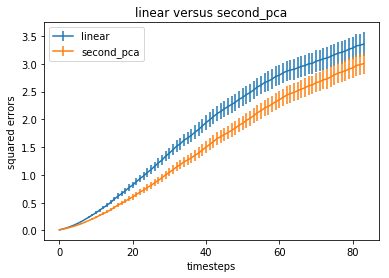

[1.6021587106260561e-59, 3.5020265478268825e-63, 1.3041917294728118e-65, 1.309604140851274e-66, 2.9522369740045898e-67, 6.6256568422361217e-68, 2.2848858614560042e-68, 1.2262556494889918e-68, 6.0582082431732202e-69, 4.2633976162578302e-69, 4.3548476124976429e-69, 5.4881736650816024e-69, 5.1707714443941796e-69, 3.349585506159096e-69, 1.2541173046600553e-68, 3.4656450365328788e-68, 6.75600725751727e-68, 8.7345351798203981e-68, 6.9606968347426231e-68, 1.7414143439141444e-67, 1.3034493102582566e-67, 1.2086605014510505e-67, 6.4363511395569178e-68, 3.239062997518364e-68, 1.5532400660073874e-68, 3.0996749978092285e-68, 2.2929543659901389e-68, 2.5536552236250747e-68, 6.9337371433060606e-68, 2.0183544086702674e-68, 1.1107072345326178e-68, 6.4150232718386828e-69, 4.9099885307315009e-69, 1.0961969741474299e-69, 2.1592751289536481e-70, 5.3294073367396235e-71, 1.0248008420649774e-71, 5.5999322368738459e-72, 3.8507702289443541e-72, 1.1982561461849246e-72, 9.5825696656216179e-73, 1.7312670600428164e-

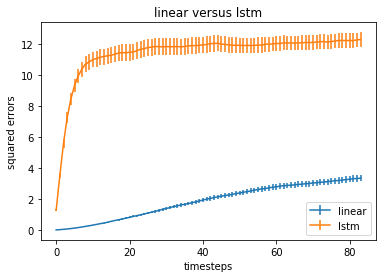

[2.3200618000548109e-101, 1.4098305829352695e-99, 3.1250677151477815e-101, 3.1521605124621e-100, 1.0981898120770637e-99, 2.155004174854549e-99, 2.7450192980671643e-98, 4.2431931228399053e-98, 3.8422063348664195e-97, 1.1807548840510038e-96, 8.50688621516311e-96, 4.6228325893217847e-95, 1.4193121099106626e-94, 1.7292050757600142e-94, 1.8333064736278178e-93, 8.4416477564282496e-93, 3.7623073194533967e-92, 7.8689481043316819e-92, 5.4591651818528942e-92, 1.3685179162294423e-91, 1.0681458945469038e-91, 9.2194298059515569e-92, 6.1329807264232509e-92, 4.3106786083910019e-92, 1.3357742517052339e-92, 2.1992938294524745e-92, 1.3135779438255597e-92, 1.0387245628046872e-92, 1.6193061909722198e-92, 2.6938287314466555e-93, 1.7285315866114327e-93, 9.126434040552692e-94, 9.0957928662459092e-94, 1.4965671147970848e-94, 2.620660361620071e-95, 5.4827376548705535e-96, 8.1450282084661445e-97, 2.827469402388534e-97, 1.0389337614279095e-97, 1.4463087769778321e-98, 6.1504454463277697e-99, 9.3747259449903982e-1

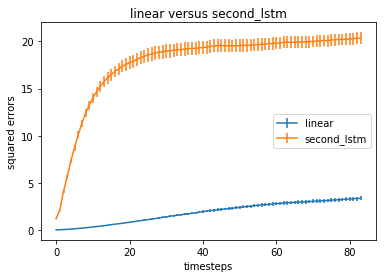

[3.8128924145756112e-27, 2.5528602615176776e-35, 1.4788855955949153e-35, 3.2235605613789774e-35, 8.6575704180544377e-36, 4.4349922173371836e-36, 1.2063068712285121e-35, 4.0976705679927177e-36, 8.460295227216313e-36, 5.6121803229899449e-36, 1.3691483461141076e-35, 1.9282483392284603e-35, 4.3606704104054556e-35, 2.2146600106968149e-34, 3.4504304646039592e-34, 2.6142697643609335e-34, 5.3429263701622346e-34, 1.0156571115765516e-33, 1.988256053058559e-33, 2.9021747927895543e-33, 3.9532644682023666e-33, 5.5574716494715855e-33, 1.2543096045985033e-32, 1.9891318127846033e-32, 4.0800302429019528e-32, 4.5370761268562265e-32, 8.1517120238439661e-32, 1.524972436946353e-31, 2.6769056664898368e-31, 4.5169208350737003e-31, 9.3274361991029054e-31, 1.184227595441586e-30, 2.4888277074479578e-30, 4.7956728447117036e-30, 9.0310583197173999e-30, 2.03858445324147e-29, 2.9395879051695064e-29, 7.0297877334157305e-29, 1.8863503898151213e-28, 4.2625395807532933e-28, 7.8208876584823969e-28, 1.8219403407042235e-2

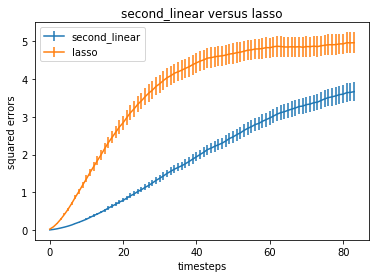

[3.8128924145756112e-27, 2.5528602615176776e-35, 1.4788855955949153e-35, 3.2235605613789774e-35, 8.6575704180544377e-36, 4.4349922173371836e-36, 1.2063068712285121e-35, 4.0976705679927177e-36, 8.460295227216313e-36, 5.6121803229899449e-36, 1.3691483461141076e-35, 1.9282483392284603e-35, 4.3606704104054556e-35, 2.2146600106968149e-34, 3.4504304646039592e-34, 2.6142697643609335e-34, 5.3429263701622346e-34, 1.0156571115765516e-33, 1.988256053058559e-33, 2.9021747927895543e-33, 3.9532644682023666e-33, 5.5574716494715855e-33, 1.2543096045985033e-32, 1.9891318127846033e-32, 4.0800302429019528e-32, 4.5370761268562265e-32, 8.1517120238439661e-32, 1.524972436946353e-31, 2.6769056664898368e-31, 4.5169208350737003e-31, 9.3274361991029054e-31, 1.184227595441586e-30, 2.4888277074479578e-30, 4.7956728447117036e-30, 9.0310583197173999e-30, 2.03858445324147e-29, 2.9395879051695064e-29, 7.0297877334157305e-29, 1.8863503898151213e-28, 4.2625395807532933e-28, 7.8208876584823969e-28, 1.8219403407042235e-2

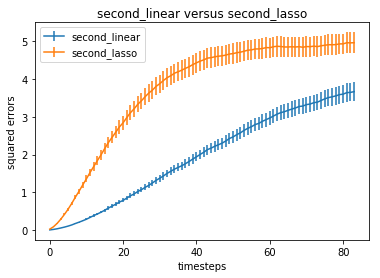

[0.0074215200419369045, 0.0014338709240322655, 0.0056445589703601924, 0.0047007414589347301, 0.0078606430595315243, 0.007395465877707179, 0.025612325214337893, 0.062152029747592485, 0.057531010397693712, 0.066031271042429618, 0.088494138590536758, 0.15553355284540318, 0.27490968621363016, 0.32487523968476428, 0.31484528562360453, 0.24850501044513723, 0.32377150160579282, 0.45965554842652578, 0.49493635306240491, 0.51990077590841977, 0.50875496695182842, 0.56729380497863957, 0.65020696673035705, 0.68539817497357425, 0.71833906771853573, 0.71372847104405313, 0.7231466848577226, 0.67554984409147045, 0.80425109560940478, 0.80103634138282975, 0.8483564728171924, 0.81544315635018239, 0.87807991630762627, 0.98386539785698901, 0.91322619148693562, 0.97108430925935929, 0.94323392450699528, 0.92967420107318266, 0.99898647293652598, 0.97596100349602066, 0.99032726982395958, 0.90744803423978637, 0.87946350475038315, 0.77779606421710223, 0.78867563510557526, 0.7775655413880227, 0.79742942806047812,

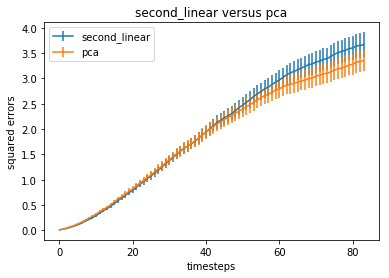

[1.2197269103654154e-05, 0.050314398167714311, 0.21333323331213871, 0.70751536648368474, 0.099603787799039736, 0.011986366682440493, 0.0004541108889612163, 1.6894610716603283e-05, 4.4405653026408279e-06, 2.1190754953018503e-07, 1.0118797000005927e-08, 1.0283123875971311e-09, 3.9389052232085433e-11, 5.6918644584605742e-12, 5.2907297060030959e-12, 8.2969221430607885e-12, 3.0824911235442602e-12, 1.9617658563234826e-13, 3.6278666151720815e-14, 7.4265544187694195e-14, 4.066070115225841e-14, 6.811239668286295e-14, 2.8895039780622924e-14, 2.3766412793259472e-14, 1.2516397348685651e-14, 1.3316566431065835e-14, 2.2266039045223117e-14, 3.278823192887309e-14, 2.4878347881654426e-14, 3.2271275455107426e-14, 2.8917591350183071e-14, 3.1297411869814697e-14, 2.4842295961798279e-14, 7.7682740137905756e-15, 1.555121410020782e-14, 1.3381535919710621e-14, 2.6963283903741629e-14, 3.8350794367151117e-14, 2.3547735418961946e-14, 3.2747008202907844e-14, 4.7362705466517817e-14, 5.0346185210664295e-14, 1.035638

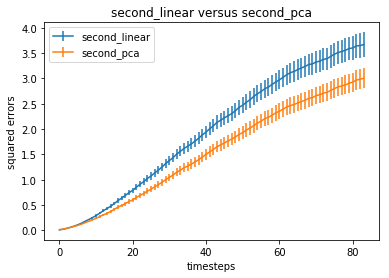

[9.8063334218951123e-60, 2.4944970644872386e-63, 1.083366446991134e-65, 1.2082936966058429e-66, 3.0393798584936361e-67, 7.0971991553908454e-68, 3.1941431993747329e-68, 2.1835025884669013e-68, 1.1812015560299912e-68, 1.0880985363829073e-68, 1.4205762040217554e-68, 2.6800171366628325e-68, 3.8041095849517444e-68, 3.757607019698674e-68, 1.7940191678286906e-67, 6.0084756249907379e-67, 1.946090432655118e-66, 4.4397403717714968e-66, 6.1426653948803151e-66, 2.3309958638901141e-65, 2.5226862296836807e-65, 4.2407942502551503e-65, 4.8909937140809705e-65, 4.3011705654011006e-65, 4.5621652165134501e-65, 1.2137317090261962e-64, 1.6452411998787819e-64, 2.5401462974813262e-64, 1.3977800976241981e-63, 7.7520010974059916e-64, 8.3508986025606282e-64, 8.2426790829872954e-64, 1.3517040618980282e-63, 8.1896300183961823e-64, 2.6928378653663915e-64, 1.8794638946582087e-64, 5.4672786124695174e-65, 4.7616444242486455e-65, 8.0235243202417997e-65, 5.7449433778280605e-65, 5.7572281479751342e-65, 2.8686801750726672

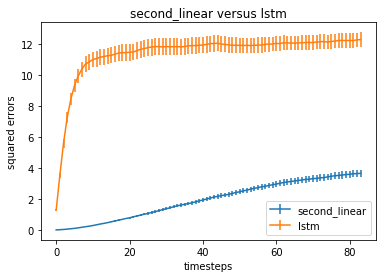

[1.3300397840415417e-101, 5.7146432170447074e-100, 1.9211459825514181e-101, 2.1288218726910817e-100, 9.0085673950950654e-100, 1.9052947008779076e-99, 3.7538045620595525e-98, 8.1070398114865524e-98, 7.9651274530268681e-97, 3.350758611419354e-96, 3.2914642733784315e-95, 2.7421966958820505e-94, 1.3179793681725998e-93, 2.5791029377926934e-93, 3.6099946144094768e-92, 2.0315946394089295e-91, 1.5023771495829173e-90, 5.6231872953802523e-90, 6.6026907000100569e-90, 2.6669321323188769e-89, 2.808626043295041e-89, 4.4202767989614771e-89, 5.6779701234043586e-89, 7.2349063979640319e-89, 4.425817973498462e-89, 1.0128345413608425e-88, 1.0538743553872463e-88, 1.1656227180374607e-88, 3.3388448543927576e-88, 1.0244571005870079e-88, 1.1431327486888287e-88, 1.0461407619883858e-88, 1.8095263485779677e-88, 7.2103341567038269e-89, 1.9669762510539457e-89, 1.0248462260010257e-89, 2.4335873983083393e-90, 1.3943204118834737e-90, 1.3504330917670666e-90, 4.0517960043016942e-91, 2.5948685982139772e-91, 1.02108375187

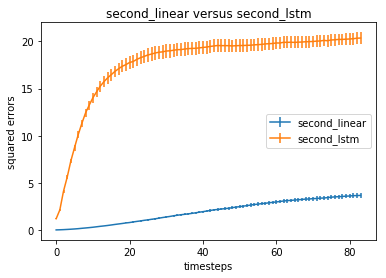

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


C:\Users\Aishu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Aishu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Aishu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


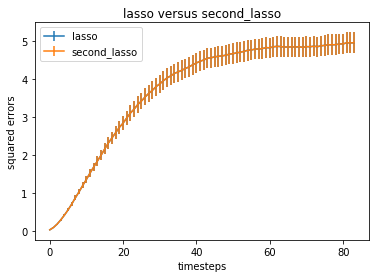

[9.5808628265204384e-32, 1.5808855270857738e-36, 2.326269422224713e-37, 5.7383738079206899e-37, 1.054046312635948e-37, 1.0449643667735357e-37, 3.5385226089976969e-38, 4.3548432960906671e-39, 5.8417342645498769e-39, 2.0786652725246133e-39, 2.793679988831192e-39, 1.1383181712616888e-39, 5.6197319601724978e-40, 7.9265587045599011e-40, 8.1765732606673614e-40, 4.5396606472287676e-40, 2.8220558122506009e-40, 1.1602667626129978e-40, 1.0186884149909447e-40, 6.2861628919344178e-41, 5.6678187915580097e-41, 3.0023665615780412e-41, 1.5757639523348213e-41, 8.0975734598116454e-42, 6.6409478360604333e-42, 3.4508331036725453e-42, 2.892188376723164e-42, 2.5067406305222676e-42, 1.3625012192263132e-42, 1.2710707515543296e-42, 9.206848662359067e-43, 6.3649134435009584e-43, 3.4862320547175465e-43, 1.0585478905619657e-43, 9.880184118156707e-44, 4.7357744525421729e-44, 3.0045334540393413e-44, 2.1995234510045123e-44, 8.9037047728758316e-45, 7.1226867140002688e-45, 3.7458211350400307e-45, 1.5953053469945102e-4

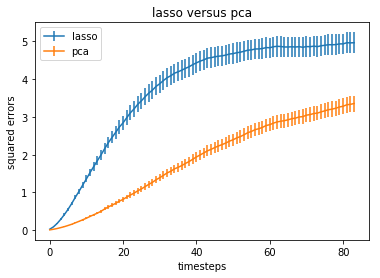

[2.7986663956978077e-16, 1.2183572077010839e-35, 1.7475451142289345e-36, 6.2609030459585484e-37, 6.0504017111994167e-38, 5.4529219312019002e-38, 3.5378739743126362e-38, 7.3518281359664224e-39, 1.1271904195868425e-38, 5.9956433162255528e-39, 7.7780658627295799e-39, 5.9972482847290437e-39, 3.7718049005434581e-39, 9.4286812173245255e-39, 1.0943114560800372e-38, 5.1258717131290997e-39, 5.2469713316361377e-39, 3.4123980276956307e-39, 3.163242593409386e-39, 2.8378751012426014e-39, 2.3353589233590942e-39, 1.6206085940601371e-39, 1.6998936392700768e-39, 1.0640358358381079e-39, 1.1664695805712697e-39, 6.4759589279548339e-40, 6.27222344317575e-40, 5.8559704649488151e-40, 3.9324494233439357e-40, 4.1235205072822444e-40, 4.2276308772934082e-40, 3.2216482219631338e-40, 2.4865278876868237e-40, 1.4649581296337596e-40, 1.6601360473006051e-40, 1.3372975500726159e-40, 9.582758512133198e-41, 9.8645852290941414e-41, 6.8664823182341797e-41, 7.2579532992796235e-41, 5.2535081053901656e-41, 3.9633713984908155e

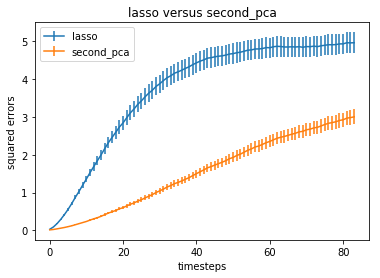

[2.0306074928009365e-59, 2.8737998102355076e-63, 7.0686346366082697e-66, 4.9298159166985958e-67, 7.2996235797866353e-68, 1.0020101027173924e-68, 2.0059691329533113e-69, 7.3799480555471113e-70, 2.2799036067472651e-70, 1.0442887371560314e-70, 6.379976614714776e-71, 4.8730919582159479e-71, 3.4529949608756169e-71, 9.6849580483984134e-72, 2.7913388297619515e-71, 4.5260583675379715e-71, 6.6292030996808159e-71, 6.6756868426625051e-71, 3.1752543749081488e-71, 9.1224950722091147e-71, 5.218356685554627e-71, 3.9102777616612042e-71, 1.2775932965064997e-71, 4.387707457027362e-72, 1.4005754701179371e-72, 2.6064378239881197e-72, 1.5979066909125681e-72, 1.1558520931430009e-72, 6.0356897517289258e-72, 1.1486783182013397e-72, 6.1170917007000202e-73, 4.7002570485084944e-73, 4.746929899919111e-73, 1.4241880732060695e-73, 2.2742284062488938e-74, 4.7704424525834311e-75, 5.4881896400795216e-76, 4.7018129379556103e-76, 7.4230139619835119e-76, 5.1298981618821673e-76, 5.1005874477960518e-76, 8.0981621839884769e

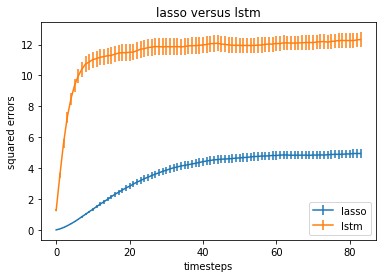

[1.8903402654814338e-102, 5.6461793448485589e-102, 3.7724071913680291e-104, 8.1845048359335066e-104, 1.00545038431014e-103, 6.1497595734313884e-104, 3.5443805481123286e-103, 2.1841836143605102e-103, 1.2183894655067721e-102, 1.7284665346377896e-102, 8.2799576297265131e-102, 2.2836827728922075e-101, 5.1542949904040906e-101, 2.2985953513299539e-101, 1.838548532492034e-100, 4.1215913049741473e-100, 1.5573986724136009e-99, 2.3355473898468132e-99, 7.0033510517707022e-100, 1.3789058176505519e-99, 5.9272141504215269e-100, 3.8442024780708022e-100, 1.4264875619410367e-100, 8.8773672969564728e-101, 1.1156767464589411e-101, 1.5147557808220041e-101, 6.127890105600679e-102, 2.6007828021364062e-102, 5.3684379246987916e-102, 4.5342255094558614e-103, 2.8196186642348488e-103, 1.2683515404264157e-103, 1.3710864669855993e-103, 2.36566504484245e-104, 3.0185216325893735e-105, 5.8146745657772028e-106, 6.1568605354294443e-107, 2.5428499004605983e-107, 1.201089166142752e-107, 1.9614181577841656e-108, 8.8065366

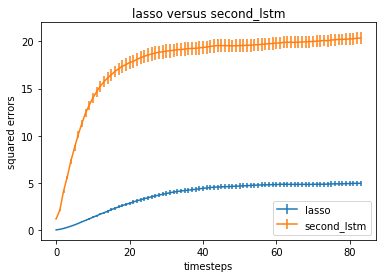

[9.5808628265204384e-32, 1.5808855270857738e-36, 2.326269422224713e-37, 5.7383738079206899e-37, 1.054046312635948e-37, 1.0449643667735357e-37, 3.5385226089976969e-38, 4.3548432960906671e-39, 5.8417342645498769e-39, 2.0786652725246133e-39, 2.793679988831192e-39, 1.1383181712616888e-39, 5.6197319601724978e-40, 7.9265587045599011e-40, 8.1765732606673614e-40, 4.5396606472287676e-40, 2.8220558122506009e-40, 1.1602667626129978e-40, 1.0186884149909447e-40, 6.2861628919344178e-41, 5.6678187915580097e-41, 3.0023665615780412e-41, 1.5757639523348213e-41, 8.0975734598116454e-42, 6.6409478360604333e-42, 3.4508331036725453e-42, 2.892188376723164e-42, 2.5067406305222676e-42, 1.3625012192263132e-42, 1.2710707515543296e-42, 9.206848662359067e-43, 6.3649134435009584e-43, 3.4862320547175465e-43, 1.0585478905619657e-43, 9.880184118156707e-44, 4.7357744525421729e-44, 3.0045334540393413e-44, 2.1995234510045123e-44, 8.9037047728758316e-45, 7.1226867140002688e-45, 3.7458211350400307e-45, 1.5953053469945102e-4

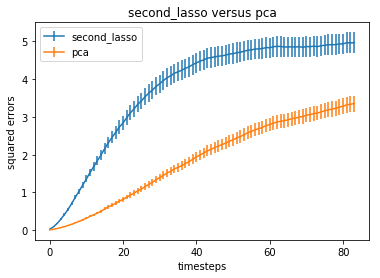

[2.7986663956978077e-16, 1.2183572077010839e-35, 1.7475451142289345e-36, 6.2609030459585484e-37, 6.0504017111994167e-38, 5.4529219312019002e-38, 3.5378739743126362e-38, 7.3518281359664224e-39, 1.1271904195868425e-38, 5.9956433162255528e-39, 7.7780658627295799e-39, 5.9972482847290437e-39, 3.7718049005434581e-39, 9.4286812173245255e-39, 1.0943114560800372e-38, 5.1258717131290997e-39, 5.2469713316361377e-39, 3.4123980276956307e-39, 3.163242593409386e-39, 2.8378751012426014e-39, 2.3353589233590942e-39, 1.6206085940601371e-39, 1.6998936392700768e-39, 1.0640358358381079e-39, 1.1664695805712697e-39, 6.4759589279548339e-40, 6.27222344317575e-40, 5.8559704649488151e-40, 3.9324494233439357e-40, 4.1235205072822444e-40, 4.2276308772934082e-40, 3.2216482219631338e-40, 2.4865278876868237e-40, 1.4649581296337596e-40, 1.6601360473006051e-40, 1.3372975500726159e-40, 9.582758512133198e-41, 9.8645852290941414e-41, 6.8664823182341797e-41, 7.2579532992796235e-41, 5.2535081053901656e-41, 3.9633713984908155e

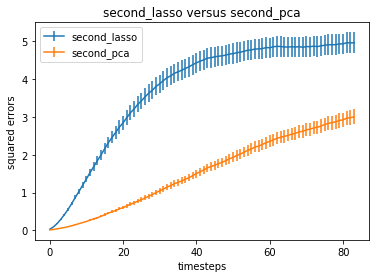

[2.0306074928009365e-59, 2.8737998102355076e-63, 7.0686346366082697e-66, 4.9298159166985958e-67, 7.2996235797866353e-68, 1.0020101027173924e-68, 2.0059691329533113e-69, 7.3799480555471113e-70, 2.2799036067472651e-70, 1.0442887371560314e-70, 6.379976614714776e-71, 4.8730919582159479e-71, 3.4529949608756169e-71, 9.6849580483984134e-72, 2.7913388297619515e-71, 4.5260583675379715e-71, 6.6292030996808159e-71, 6.6756868426625051e-71, 3.1752543749081488e-71, 9.1224950722091147e-71, 5.218356685554627e-71, 3.9102777616612042e-71, 1.2775932965064997e-71, 4.387707457027362e-72, 1.4005754701179371e-72, 2.6064378239881197e-72, 1.5979066909125681e-72, 1.1558520931430009e-72, 6.0356897517289258e-72, 1.1486783182013397e-72, 6.1170917007000202e-73, 4.7002570485084944e-73, 4.746929899919111e-73, 1.4241880732060695e-73, 2.2742284062488938e-74, 4.7704424525834311e-75, 5.4881896400795216e-76, 4.7018129379556103e-76, 7.4230139619835119e-76, 5.1298981618821673e-76, 5.1005874477960518e-76, 8.0981621839884769e

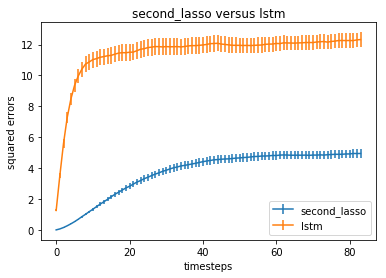

[1.8903402654814338e-102, 5.6461793448485589e-102, 3.7724071913680291e-104, 8.1845048359335066e-104, 1.00545038431014e-103, 6.1497595734313884e-104, 3.5443805481123286e-103, 2.1841836143605102e-103, 1.2183894655067721e-102, 1.7284665346377896e-102, 8.2799576297265131e-102, 2.2836827728922075e-101, 5.1542949904040906e-101, 2.2985953513299539e-101, 1.838548532492034e-100, 4.1215913049741473e-100, 1.5573986724136009e-99, 2.3355473898468132e-99, 7.0033510517707022e-100, 1.3789058176505519e-99, 5.9272141504215269e-100, 3.8442024780708022e-100, 1.4264875619410367e-100, 8.8773672969564728e-101, 1.1156767464589411e-101, 1.5147557808220041e-101, 6.127890105600679e-102, 2.6007828021364062e-102, 5.3684379246987916e-102, 4.5342255094558614e-103, 2.8196186642348488e-103, 1.2683515404264157e-103, 1.3710864669855993e-103, 2.36566504484245e-104, 3.0185216325893735e-105, 5.8146745657772028e-106, 6.1568605354294443e-107, 2.5428499004605983e-107, 1.201089166142752e-107, 1.9614181577841656e-108, 8.8065366

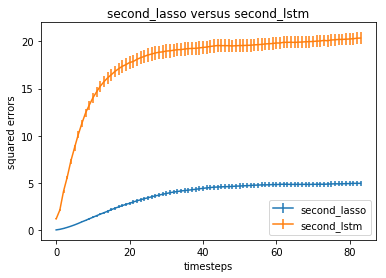

[0.082468791729078991, 0.0075750357342580527, 0.0053578464377627734, 6.7944593454988276e-07, 1.1932410777242999e-09, 1.3367527494756086e-12, 1.6441636512665763e-13, 2.3444949089431215e-14, 1.3302212956999607e-14, 3.659353592736504e-15, 1.8605859580108431e-15, 2.9018492895863511e-15, 6.6316962406420176e-15, 4.8989045081531275e-15, 4.1675367513453759e-15, 8.9781847232507891e-16, 2.9381597689472135e-15, 3.7988357029923364e-15, 4.4268081721472646e-15, 2.6709410341872502e-15, 1.3754763983048997e-15, 1.5681584694968552e-15, 4.9402692120978938e-15, 3.683805397362178e-15, 4.1154425547900589e-15, 3.224412904805895e-15, 4.2725212689338837e-15, 2.9139655573327622e-15, 6.6094976745705964e-15, 5.2161995520262183e-15, 7.7139259846026147e-15, 4.3052505511665022e-15, 8.1608339760976785e-15, 1.6632939390890476e-14, 1.4844208103041639e-14, 2.6622524958025103e-14, 2.5873005747170262e-14, 3.3128263886022824e-14, 4.4883317681654585e-14, 8.2973153687961903e-14, 9.8518282222957676e-14, 2.5664106579531597e-13

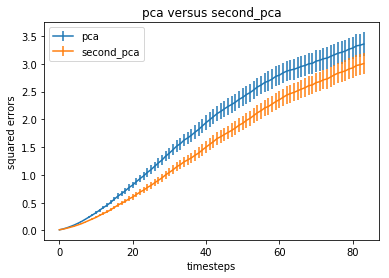

[1.6021587106259188e-59, 3.5020265478265829e-63, 1.3041917294727747e-65, 1.309604140851274e-66, 2.9522369740045898e-67, 6.6256568422368778e-68, 2.2848858614561994e-68, 1.2262556494889918e-68, 6.058208243173912e-69, 4.2633976162584376e-69, 4.3548476124985118e-69, 5.4881736650822273e-69, 5.1707714443946223e-69, 3.3495855061598589e-69, 1.2541173046603767e-68, 3.4656450365346561e-68, 6.756007257519964e-68, 8.7345351798228854e-68, 6.9606968347451994e-68, 1.7414143439145408e-67, 1.303449310258479e-67, 1.2086605014512917e-67, 6.4363511395582018e-68, 3.2390629975187326e-68, 1.5532400660078742e-68, 3.0996749978100233e-68, 2.2929543659905309e-68, 2.5536552236259478e-68, 6.9337371433062583e-68, 2.0183544086706697e-68, 1.1107072345330292e-68, 6.4150232718419721e-69, 4.909988530732899e-69, 1.0961969741478668e-69, 2.1592751289546323e-70, 5.3294073367415973e-71, 1.0248008420657071e-71, 5.5999322368775146e-72, 3.850770228946767e-72, 1.1982561461857435e-72, 9.5825696656284407e-73, 1.7312670600442955e-7

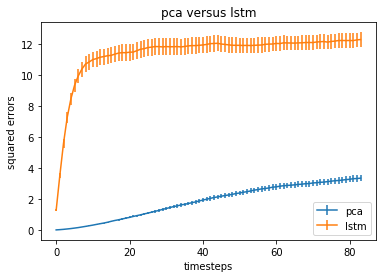

[2.3200618000548109e-101, 1.4098305829355907e-99, 3.1250677151484928e-101, 3.1521605124636248e-100, 1.0981898120777824e-99, 2.1550041748560206e-99, 2.7450192980693519e-98, 4.2431931228431649e-98, 3.842206334869918e-97, 1.1807548840521464e-96, 8.5068862151720683e-96, 4.6228325893273107e-95, 1.41931210991248e-94, 1.7292050757624255e-94, 1.8333064736306876e-93, 8.4416477564431457e-93, 3.7623073194600344e-92, 7.8689481043462394e-92, 5.4591651818637708e-92, 1.36851791623213e-91, 1.0681458945490322e-91, 9.2194298059715019e-92, 6.1329807264368648e-92, 4.3106786084011856e-92, 1.3357742517086554e-92, 2.1992938294582953e-92, 1.313577943829149e-92, 1.0387245628079096e-92, 1.619306190976967e-92, 2.6938287314553958e-93, 1.7285315866175333e-93, 9.1264340405880182e-94, 9.0957928662800793e-94, 1.4965671148030478e-94, 2.6206603616313327e-95, 5.4827376548953636e-96, 8.1450282085057811e-97, 2.8274694024026957e-97, 1.0389337614333494e-97, 1.4463087769858995e-98, 6.1504454463638256e-99, 9.3747259450485516e

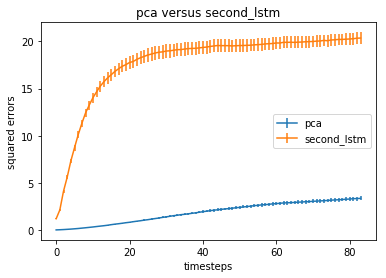

[2.3838105006334369e-59, 3.163919013707361e-63, 1.2545732937932893e-65, 1.2250681594796749e-66, 2.687764333067085e-67, 6.1286312802451152e-68, 2.2806809146533893e-68, 1.3298308873461177e-68, 6.5196391222286715e-69, 5.0983940184296585e-69, 5.2123848714883819e-69, 7.8697446216740747e-69, 7.7581042699898045e-69, 5.9298349092629975e-69, 2.3892778538953608e-68, 6.6954899214221058e-68, 1.5951257550219637e-67, 2.4219037999965333e-67, 2.2350020010688815e-67, 6.5709848429327564e-67, 5.1915795096872699e-67, 5.9527212937830571e-67, 4.568784199970877e-67, 2.7523006751424564e-67, 1.7932573765031786e-67, 3.8340627305987996e-67, 3.5518034536682833e-67, 4.1836426572568186e-67, 1.3464138672486191e-66, 5.0012579328163951e-67, 3.5093621994570069e-67, 2.4505398567875279e-67, 2.2766894161023207e-67, 7.626683659668288e-68, 1.7699024208343294e-68, 6.9754356200218773e-69, 1.55621385770202e-69, 9.5703658711787529e-70, 8.0938791047991781e-70, 3.3417516530654646e-70, 2.6630806786292495e-70, 7.2641830973477016e-7

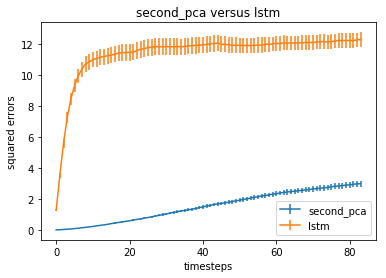

[4.2972131489275466e-101, 1.0833004972414049e-99, 2.6696499589084538e-101, 2.7391381810106771e-100, 9.646791623644947e-100, 2.0762054623669495e-99, 3.2340615968837034e-98, 5.9582659493219806e-98, 5.50572958829001e-97, 2.0217187207962234e-96, 1.5274277966279113e-95, 1.0610633156567375e-94, 3.5255389063322355e-94, 5.434173064111599e-94, 6.48215308757605e-93, 3.1936788120331534e-92, 1.759182260548722e-91, 4.5294343958057649e-91, 3.7754755349050393e-91, 1.2069803954389661e-90, 1.0296236870553926e-90, 1.1351787670053709e-90, 1.064581945278024e-90, 9.1361183704950338e-91, 3.9089741338021725e-91, 7.213293601736855e-91, 5.4718687518335132e-91, 4.8857233852787451e-91, 9.3271670851302629e-91, 2.0815469207009886e-91, 1.6897547533064248e-91, 1.1389820390378777e-91, 1.3677210684792553e-91, 3.3324358749580143e-92, 7.0436350574111818e-93, 2.2319407187694641e-93, 4.0050692214298195e-94, 1.6981283683652478e-94, 8.7508839477452948e-95, 1.7093659772726918e-95, 8.4092144665734432e-96, 1.9401429657801207e-

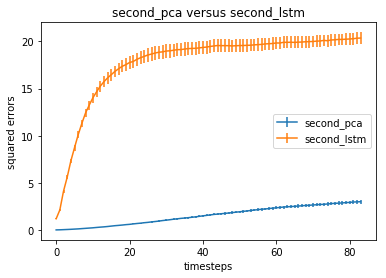

[0.017105023820398014, 6.9403904620586465e-30, 4.4115817958703449e-20, 2.6146707692103196e-18, 1.3555056169466213e-09, 0.00049906320685021296, 0.38479750164810123, 1.1415651118502136e-09, 9.5259722576416929e-33, 7.0977916841845397e-64, 2.2153504449746848e-95, 2.1182258544747598e-117, 1.389311672076257e-128, 4.5631015645142662e-135, 1.0477738787846014e-137, 2.0001766625729819e-139, 6.0036456384133852e-138, 3.3207566463392461e-137, 1.5589549158344381e-136, 2.3129364031150148e-135, 6.8861178141937723e-135, 2.3151081920506297e-134, 8.3582295420330167e-135, 1.8114460701852146e-134, 1.4605690961690898e-134, 5.0260753623790087e-134, 2.8759727915557479e-134, 1.3452227186334933e-134, 4.0215848797118863e-135, 1.7464332545260872e-135, 3.062824212055592e-135, 7.7720719416231614e-135, 1.8309854685583157e-134, 2.1704113887422801e-134, 1.5243101702088462e-134, 7.9292808599053328e-135, 1.3580470621537699e-135, 1.5534048085864717e-136, 2.1941032278990199e-136, 1.5337232051749313e-137, 6.931993778528699

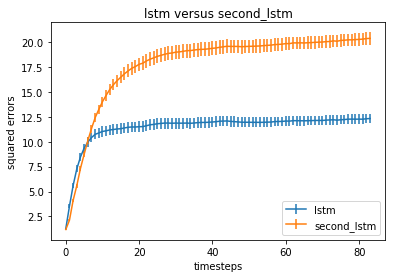

In [37]:
cigraphs(methods, electricalshop_mean, electricalshop_sem, electricalshop_sq, 60*7)

[0.0019827359186208172, 0.00070941311865353317, 0.0022114748174473626, 0.0027862350305709847, 0.0089476733053087919, 0.0457805303491736, 0.11536407124838348, 0.11720976881047995, 0.097626409284329585, 0.060086382993615212, 0.083783288238003253, 0.097500549653479512, 0.098662699731270176, 0.086894569857200649, 0.093460678764731853, 0.13333729837773689, 0.070544417753846372, 0.052782239283996196, 0.033655179953311312, 0.020487865488956654, 0.019016484300527367, 0.014842582918468638, 0.0098036509880976321, 0.007767608971119026, 0.0046409649652577253, 0.0022149313721403206, 0.00085035290613476268, 0.00051681657699181947, 0.00043539884758491554, 0.00022094579046349664, 0.00015134880259606851, 5.5097744431038478e-05, 2.6845176969873669e-05, 9.5216364618939209e-06, 3.4889198768294586e-06, 1.9214416465124715e-06, 1.4581062076667928e-06, 1.2310776801181747e-06, 3.8385565580278057e-07, 1.9366052248721326e-07, 5.3317947165587134e-08, 2.6226176798411528e-08, 1.3551031182538978e-08, 4.5482263871979

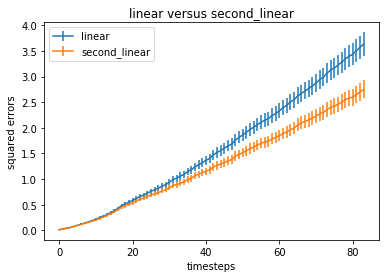

[2.2250314956704219e-12, 3.5591351309592126e-16, 1.9768144692903791e-18, 1.8928465389640397e-20, 3.4391494243147746e-23, 2.014369076585954e-25, 2.1433322064198965e-26, 4.9607455674512777e-27, 8.9784359803882117e-28, 3.3050816932927582e-28, 8.150035103367308e-29, 6.1640578934880684e-30, 3.2868796909071686e-31, 9.7547856907660039e-32, 1.6404529639020668e-31, 1.5166313080614972e-32, 1.9297367489804026e-32, 1.9961142739513176e-32, 1.9360410753898778e-32, 1.1596371824828186e-32, 2.9601096576623585e-33, 1.0368053035655253e-33, 1.9852766715110868e-33, 3.3486345075393919e-33, 1.046574185723774e-33, 4.913144756042131e-33, 5.9815325917584616e-33, 4.3368648461080703e-33, 4.2941582203038466e-33, 5.1184849926496089e-33, 8.8194870486706215e-33, 3.1898737979105121e-32, 1.2838243149804923e-31, 6.6228241971391724e-31, 1.0664449479219162e-30, 6.4451728782413561e-30, 5.5247639833990891e-30, 1.2634442348201242e-29, 6.2997565287008578e-29, 1.9517977346258844e-28, 6.500670158001579e-28, 1.5347827621826416e-

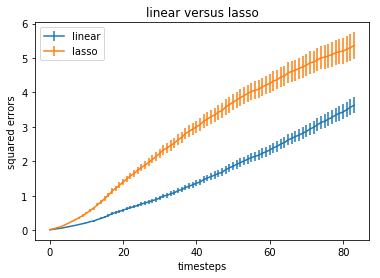

[2.2250314956704219e-12, 3.5591351309592126e-16, 1.9768144692903791e-18, 1.8928465389640397e-20, 3.4391494243147746e-23, 2.014369076585954e-25, 2.1433322064198965e-26, 4.9607455674512777e-27, 8.9784359803882117e-28, 3.3050816932927582e-28, 8.150035103367308e-29, 6.1640578934880684e-30, 3.2868796909071686e-31, 9.7547856907660039e-32, 1.6404529639020668e-31, 1.5166313080614972e-32, 1.9297367489804026e-32, 1.9961142739513176e-32, 1.9360410753898778e-32, 1.1596371824828186e-32, 2.9601096576623585e-33, 1.0368053035655253e-33, 1.9852766715110868e-33, 3.3486345075393919e-33, 1.046574185723774e-33, 4.913144756042131e-33, 5.9815325917584616e-33, 4.3368648461080703e-33, 4.2941582203038466e-33, 5.1184849926496089e-33, 8.8194870486706215e-33, 3.1898737979105121e-32, 1.2838243149804923e-31, 6.6228241971391724e-31, 1.0664449479219162e-30, 6.4451728782413561e-30, 5.5247639833990891e-30, 1.2634442348201242e-29, 6.2997565287008578e-29, 1.9517977346258844e-28, 6.500670158001579e-28, 1.5347827621826416e-

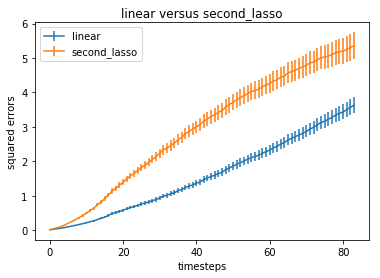

[0.0060160977486079358, 0.00084614619697372909, 0.00061762783497896622, 0.00030057763081520059, 5.0826851688536263e-05, 4.5820806437110061e-06, 1.3344642368170117e-05, 1.8655104845460198e-05, 1.2735371524395644e-05, 4.035787388337197e-05, 2.8408339963107825e-05, 1.4158413465841164e-05, 5.3294528092935085e-06, 2.6829526667755065e-06, 5.3224141354149887e-06, 1.7112827072873842e-06, 1.6048157400566892e-06, 1.4632938570589072e-06, 3.5833511118149639e-06, 4.0456820172254983e-06, 4.2294442554725807e-06, 5.9823706007964199e-06, 1.2900401275967751e-05, 2.130287383532754e-05, 1.7211000724162478e-05, 4.6675639964764676e-05, 0.00012587598452359447, 0.00018172430027856118, 0.00026577254755926025, 0.0003328749313129999, 0.00056770417835347352, 0.00097392793168657715, 0.0016104544573104812, 0.0037126308408580778, 0.0047690916664752479, 0.0078346184325538398, 0.011090629366316447, 0.012909957153907772, 0.020991848928483971, 0.029233529350206695, 0.052283916182237419, 0.071400528616659575, 0.098162678

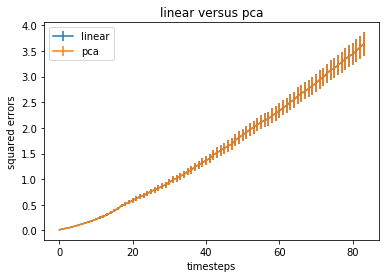

[0.00087510410806275517, 0.0031402530764778405, 0.005675784097769465, 0.013970644156860643, 0.0088257368144829384, 0.0093432206920805866, 0.014596101398528804, 0.033306044726270453, 0.076965443898907873, 0.23288037069383286, 0.49980535860538322, 0.77710543690176148, 0.90372318081948899, 0.97530589864463246, 0.76079562950450841, 0.73878094665760163, 0.56460674393053134, 0.48561520690024684, 0.39592045822581623, 0.25620240360186652, 0.20992037605556432, 0.1486689091104974, 0.084968057112077194, 0.055468557349630715, 0.044435820393875614, 0.021080894929326854, 0.0090195841927188537, 0.0045648721546695985, 0.0027031015182946614, 0.001490402964281969, 0.0010003158153706893, 0.00054521722691125494, 0.00025216627159641361, 8.3201843665344039e-05, 3.7115442871355616e-05, 1.5961601357618004e-05, 1.0283755192033192e-05, 6.8214783809142592e-06, 2.7823875529935798e-06, 1.2416062935611673e-06, 2.5862738693437319e-07, 9.3113338441577893e-08, 3.8741554511613168e-08, 8.9224223809710783e-09, 3.97302586

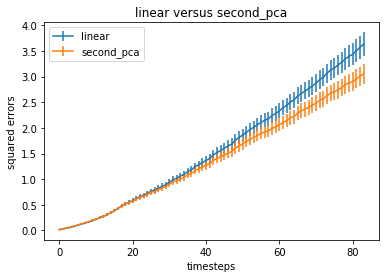

[5.1153531084049061e-70, 2.4184575364148189e-87, 6.3252729781724374e-88, 5.6073518379139942e-89, 5.3802914407675963e-90, 1.5240420198763476e-91, 1.130294748342026e-92, 1.165279667921743e-93, 8.4697381066091078e-94, 3.3048651249471369e-93, 6.8556652087629248e-93, 1.1854255111537938e-92, 2.5735172651647245e-93, 1.4215237737087647e-92, 1.0008545054113114e-92, 1.5735324828363534e-91, 1.4586839544654657e-91, 9.0638293494803479e-90, 1.2119449899177729e-88, 1.2807923105090045e-87, 3.8785187084507425e-86, 4.5572127414359462e-85, 1.3047819501516426e-83, 1.5353452624254804e-82, 3.6324648739960177e-81, 1.3523024557552346e-80, 5.5332208778775496e-80, 5.0369143307630089e-79, 4.9141153112091317e-78, 2.8038607248135206e-77, 6.3175662352338013e-76, 5.6700436840835889e-74, 4.4075566952012969e-73, 1.593201305208343e-71, 2.1902448277841783e-70, 8.9850956343132483e-70, 1.2769787859432315e-68, 1.0235695818028408e-68, 6.0530826982047739e-68, 6.4830595086539648e-67, 8.2698131528463735e-66, 1.215137636818211e

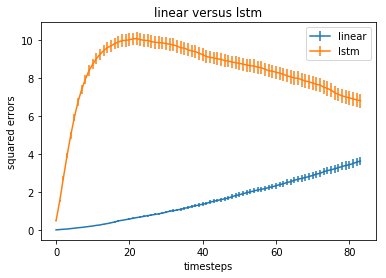

[1.5848856053602682e-59, 2.975731539791723e-60, 1.6166214410098773e-58, 5.2075874234304841e-57, 8.3436163459510258e-56, 2.1908426079420047e-55, 1.4260291460605137e-55, 7.8073754850898749e-55, 2.063474467689774e-53, 4.6619495541202268e-52, 3.6792053529608893e-51, 1.0601434403367246e-49, 3.3578174707220502e-48, 9.5370397651284888e-47, 6.2165935276461895e-46, 2.5907304436185786e-45, 3.1644254626955092e-44, 1.9445378004117731e-43, 2.9761180021239456e-42, 5.958084466517015e-41, 2.1094046422224289e-39, 1.6663793735445932e-38, 3.6903695161576985e-38, 2.1744518610279672e-36, 1.4526850260487104e-34, 6.0285450835260035e-33, 1.6891506306324623e-32, 1.9891848215377139e-31, 4.4050986367368642e-31, 1.4189332861096517e-30, 1.1741988721352464e-29, 7.5559917957757517e-29, 4.0275284350786294e-28, 5.9465388458225352e-27, 9.4257757064706913e-26, 1.9399889030077813e-24, 5.2828231742649807e-23, 7.5789283426714138e-22, 5.6276756180224741e-21, 9.3514275976187727e-20, 1.5890729363314781e-18, 1.8694694220497438

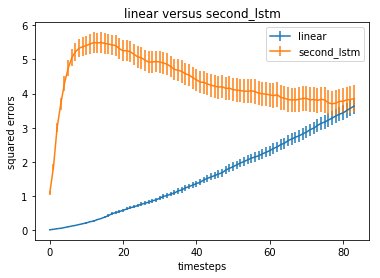

[5.7782800540694892e-09, 8.9479565868724357e-15, 7.8018067350275407e-19, 1.5287663866222627e-22, 2.3077564728129277e-27, 2.0984184492182337e-31, 1.039613614421161e-32, 9.4219897385253022e-34, 3.2425808427051225e-35, 9.8339591703518087e-36, 2.4763687393924982e-36, 4.0983058251816721e-37, 2.7072788907234978e-38, 2.0356247846845581e-38, 3.2971742659430429e-38, 1.689478403031121e-39, 2.4595604196103794e-39, 3.0250994488504306e-39, 1.3770390544098572e-39, 6.0041158353557332e-40, 1.3944921234721981e-40, 7.1538752669738388e-41, 7.61296650534376e-41, 8.9422756198761813e-41, 1.7755524966620902e-41, 8.1297593339923709e-41, 1.0539573698636011e-40, 5.8406646165408309e-41, 5.3791716980656785e-41, 4.9522905801472886e-41, 6.8229472876163956e-41, 2.2333219395508625e-40, 8.7930076686074353e-40, 1.9087522832581556e-39, 3.9484047740600702e-39, 1.2155951809522122e-38, 7.4175132355693876e-39, 1.4525572427929115e-38, 5.8877813762073887e-38, 1.8533323922175255e-37, 3.7138272506099409e-37, 8.3773799197957131e

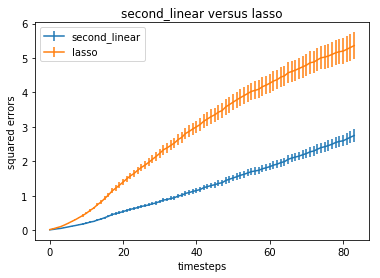

[5.7782800540694892e-09, 8.9479565868724357e-15, 7.8018067350275407e-19, 1.5287663866222627e-22, 2.3077564728129277e-27, 2.0984184492182337e-31, 1.039613614421161e-32, 9.4219897385253022e-34, 3.2425808427051225e-35, 9.8339591703518087e-36, 2.4763687393924982e-36, 4.0983058251816721e-37, 2.7072788907234978e-38, 2.0356247846845581e-38, 3.2971742659430429e-38, 1.689478403031121e-39, 2.4595604196103794e-39, 3.0250994488504306e-39, 1.3770390544098572e-39, 6.0041158353557332e-40, 1.3944921234721981e-40, 7.1538752669738388e-41, 7.61296650534376e-41, 8.9422756198761813e-41, 1.7755524966620902e-41, 8.1297593339923709e-41, 1.0539573698636011e-40, 5.8406646165408309e-41, 5.3791716980656785e-41, 4.9522905801472886e-41, 6.8229472876163956e-41, 2.2333219395508625e-40, 8.7930076686074353e-40, 1.9087522832581556e-39, 3.9484047740600702e-39, 1.2155951809522122e-38, 7.4175132355693876e-39, 1.4525572427929115e-38, 5.8877813762073887e-38, 1.8533323922175255e-37, 3.7138272506099409e-37, 8.3773799197957131e

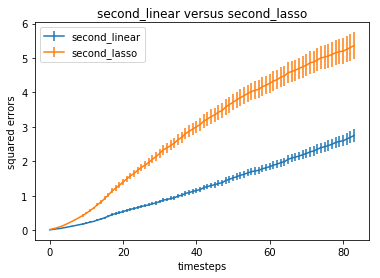

[0.0019827359186174345, 0.00070941311865114045, 0.0022114748174363245, 0.0027862350305507527, 0.0089476733052238269, 0.045780530348749494, 0.11536407124751781, 0.11720976880963577, 0.09762640928358951, 0.060086382993133014, 0.083783288237364806, 0.097500549652742421, 0.098662699730459935, 0.086894569856434234, 0.093460678763945482, 0.13333729837662958, 0.070544417753159699, 0.05278223928344343, 0.033655179952937535, 0.020487865488707957, 0.019016484300292232, 0.014842582918276665, 0.0098036509879663725, 0.0077676089710133015, 0.0046409649651893148, 0.0022149313721063321, 0.00085035290612104925, 0.00051681657698320299, 0.00043539884757743796, 0.00022094579045948054, 0.00015134880259325465, 5.5097744429969286e-05, 2.6845176969345358e-05, 9.5216364617034435e-06, 3.4889198767573265e-06, 1.9214416464720515e-06, 1.4581062076365692e-06, 1.2310776800921918e-06, 3.8385565579455286e-07, 1.9366052248307506e-07, 5.331794716445432e-08, 2.6226176797861112e-08, 1.3551031182250656e-08, 4.5482263871028

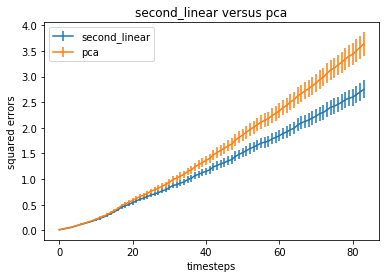

[9.9309494536702585e-05, 2.952887942777542e-05, 0.00016544847271683484, 0.00026602961591038859, 0.00017794123260344042, 0.00040873753408235137, 0.001618883883575561, 0.0032131820395103444, 0.0054668085922537513, 0.0069438644853237518, 0.022773035220195283, 0.040416847754076474, 0.044713065980370288, 0.042135912900589635, 0.060572234485414808, 0.09371110651711935, 0.050956220498135633, 0.040433912286757225, 0.02485882339841403, 0.01734832057443151, 0.018254654977382209, 0.016675428823971369, 0.013989463063424813, 0.013076227513641302, 0.0082289551217606394, 0.005284018649203923, 0.0029053169086656755, 0.0022414302246135409, 0.002481088649303821, 0.001710132582185647, 0.0014558383413756286, 0.00066396436855620635, 0.00047366050922127158, 0.00026206278084804884, 0.00014995049078027255, 0.00011834789774809475, 0.00011401204002260875, 0.00011895530140788158, 5.4616773381548676e-05, 3.6934546659227619e-05, 1.8623790102423216e-05, 1.5344489305699827e-05, 1.3084935334818459e-05, 8.103104135415

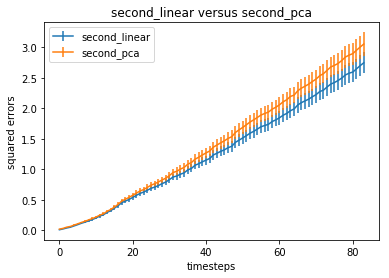

[8.0265107174754246e-71, 1.4680419971705936e-87, 4.5255663799311813e-88, 4.3658502798217128e-89, 3.7693577225869867e-90, 9.4475922681881701e-92, 5.895062198223507e-93, 4.7312443379099038e-94, 2.6487228801684998e-94, 7.9757119748390309e-94, 1.4299545155207417e-93, 1.8351816352414987e-93, 3.0152548542718851e-94, 1.2523811822541152e-93, 6.5898433122570333e-94, 8.8346039680454344e-93, 4.7573457923759348e-93, 2.2053219506778642e-91, 2.0874947597850762e-90, 1.4803895514969969e-89, 4.0192898685469387e-88, 4.1725445052349881e-87, 1.0424409600689314e-85, 8.470578302772846e-85, 1.5158605616261966e-83, 4.3510126883119843e-83, 1.463230613476762e-82, 1.133814766146862e-81, 1.2154104186332614e-80, 5.9054651652973094e-80, 1.1792795895696664e-78, 7.5377161735559789e-77, 4.6386272255538609e-76, 1.0321137004860579e-74, 8.7530520856750631e-74, 3.0517608858705976e-73, 2.7020055122169146e-72, 1.5708085591598168e-72, 5.5692023866685283e-72, 3.4652908593710616e-71, 2.4050006829370068e-70, 2.4599500838376743e

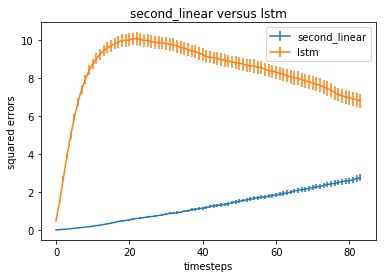

[1.0312792103495692e-59, 1.9414232829552604e-60, 1.1875362572887333e-58, 3.9803476548709582e-57, 6.2205862569352058e-56, 1.6020546617446737e-55, 9.6715629446474227e-56, 4.5383585237269502e-55, 9.9091617345856946e-54, 1.7670775053647289e-52, 1.2931192117270674e-51, 3.3588754616459447e-50, 9.5073868842462327e-49, 2.2331170226557512e-47, 1.200303064666978e-46, 4.2707796681139163e-46, 3.6557659624509837e-45, 1.5798984118039471e-44, 1.7808357457489476e-43, 2.6901642530271989e-42, 8.6167394071712756e-41, 6.0305525750047561e-40, 1.0482716549613125e-39, 5.6772065268422075e-38, 3.3157980651517796e-36, 1.1764604577174303e-34, 2.4400179682053187e-34, 2.3766434143381806e-33, 5.2549970315400859e-33, 1.3596312538601327e-32, 1.0294524118126513e-31, 4.6368680831769561e-31, 1.9391110089536091e-30, 1.8579051271244464e-29, 2.3486850376123446e-28, 4.2362132382168884e-27, 1.1182506299691856e-25, 1.4586271910315786e-24, 8.2064714755414912e-24, 1.093551445908167e-22, 1.5446062410865075e-21, 1.745345123809404

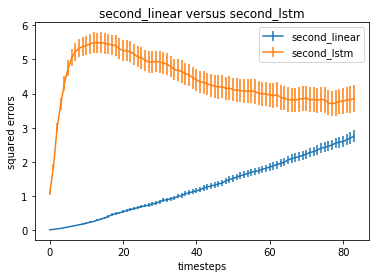

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


C:\Users\Aishu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Aishu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Aishu\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


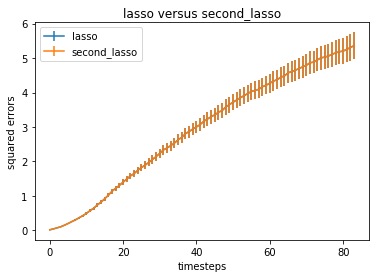

[2.2250314956607417e-12, 3.5591351309336545e-16, 1.9768144692727819e-18, 1.8928465389468719e-20, 3.4391494242808116e-23, 2.0143690765657249e-25, 2.1433322063961243e-26, 4.9607455673927196e-27, 8.9784359802773723e-28, 3.3050816932482055e-28, 8.1500351032555371e-29, 6.1640578934009181e-30, 3.2868796908588799e-31, 9.7547856906199208e-32, 1.6404529638772176e-31, 1.5166313080380088e-32, 1.929736748949909e-32, 1.9961142739193751e-32, 1.9360410753579851e-32, 1.1596371824632358e-32, 2.9601096576118704e-33, 1.0368053035471467e-33, 1.9852766714752131e-33, 3.3486345074788801e-33, 1.0465741857045946e-33, 4.9131447559506771e-33, 5.9815325916433595e-33, 4.3368648460223872e-33, 4.2941582202168608e-33, 5.1184849925459231e-33, 8.8194870484883008e-33, 3.189873797844061e-32, 1.2838243149539822e-31, 6.6228241969998352e-31, 1.0664449478994788e-30, 6.4451728781053573e-30, 5.5247639832801448e-30, 1.263444234792884e-29, 6.2997565285641998e-29, 1.9517977345834547e-28, 6.5006701578576834e-28, 1.534782762148632e

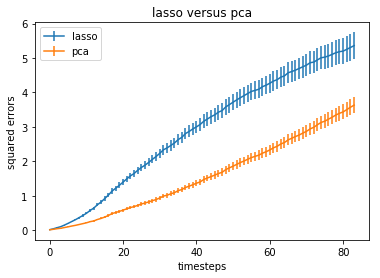

[0.10323793551209488, 4.1556872469121632e-08, 2.6735326236534768e-10, 6.244362157525722e-19, 5.5830796841800741e-23, 3.2665769326648773e-27, 2.8218616869091383e-28, 2.0905130493492148e-29, 2.7912384450904851e-30, 5.5366756021007918e-31, 9.0150866640526821e-32, 5.0338778480198802e-33, 2.1232361030520749e-34, 4.6298094806773821e-35, 6.7836974594260143e-35, 5.1285804725082042e-36, 5.1541322468097874e-36, 4.6101298682309685e-36, 3.8448454034860276e-36, 1.7908363793766826e-36, 3.8414946533533234e-37, 1.0681463060362763e-37, 1.672094782590059e-37, 2.9401183414243267e-37, 7.0400090710152849e-38, 2.4593065059975424e-37, 2.6096048354401784e-37, 1.4363608489934978e-37, 1.2594596796029298e-37, 1.3788781551015331e-37, 2.1381717740134925e-37, 7.7391186804509824e-37, 3.0817654211331882e-36, 1.050594286579699e-35, 1.7153015062160786e-35, 8.7645102834936665e-35, 6.2366872197801245e-35, 1.48566200527277e-34, 6.971167352820828e-34, 1.9667802217848711e-33, 4.6336696792213748e-33, 1.0368600115516428e-32, 

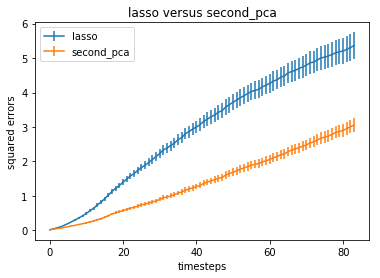

[4.9316722290638291e-68, 3.9056947296385526e-86, 7.122404420065223e-87, 8.2406707026323299e-88, 1.5996053567924758e-88, 1.176189856450025e-89, 1.9172958195191936e-90, 4.069074826934006e-91, 5.7632916823714995e-91, 4.6435881895166122e-90, 2.1359170310134501e-89, 1.2508013500709192e-88, 6.4014780035161004e-89, 1.5278633065337043e-87, 2.1864885989705737e-87, 1.4203503695923245e-85, 3.8260538007111687e-85, 5.3751455266805644e-83, 9.132055510169389e-82, 2.6810273405851022e-80, 3.6688378704927898e-78, 1.6970618759821848e-76, 1.8177771314566602e-74, 6.0098163427155491e-73, 9.470168026183022e-71, 2.0226710962675637e-69, 2.4375016730458046e-68, 1.3833933407069516e-66, 9.9667049623109656e-65, 2.0887339241410618e-63, 1.4711899366866825e-61, 3.6774410911992304e-59, 3.6111949104821616e-58, 2.2214599411918948e-56, 9.3756509766582517e-55, 1.5755615041981006e-53, 3.9298551814282314e-52, 5.9357051838361763e-51, 4.4424662529606868e-50, 1.7242649066771006e-48, 3.3538951533941291e-47, 1.9923747976911559e-

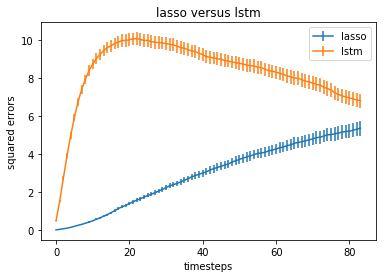

[3.535948579761221e-59, 6.4644217184159781e-60, 3.008343327588517e-58, 1.1111270394593157e-56, 2.4741690383950357e-55, 9.9912884732172261e-55, 8.776495959886682e-55, 6.0720248779687872e-54, 2.7397427562715069e-52, 1.0187910517302601e-50, 1.1440373293624265e-49, 6.4113403579070105e-48, 3.925552623019091e-46, 3.4123725657495678e-44, 4.0035451858303418e-43, 4.4598548360816166e-42, 2.5269101057774313e-40, 4.6956441529164314e-39, 1.4811728215927901e-37, 9.6361786583566409e-36, 1.3296599352690285e-33, 4.1224773415049766e-32, 3.0296242041915047e-31, 4.039091434798589e-29, 1.1212504154512859e-26, 1.0885868106474855e-24, 7.7335515831632306e-24, 2.7939373985698094e-22, 2.163510194569239e-21, 1.4615919030938978e-20, 2.6958332562785471e-19, 6.6062677644884212e-18, 5.5812172283699842e-17, 1.3818110942667809e-15, 4.9046692738652016e-14, 1.1276275299776661e-12, 2.2825666939646114e-11, 6.9923541418992538e-10, 5.06727886547583e-09, 9.0604692910395304e-08, 8.7597357459750553e-07, 8.9509426039666795e-06,

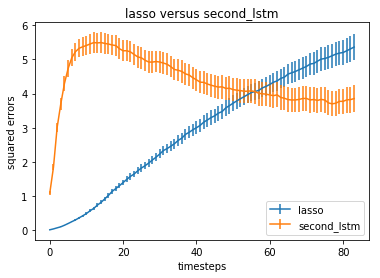

[2.2250314956607417e-12, 3.5591351309336545e-16, 1.9768144692727819e-18, 1.8928465389468719e-20, 3.4391494242808116e-23, 2.0143690765657249e-25, 2.1433322063961243e-26, 4.9607455673927196e-27, 8.9784359802773723e-28, 3.3050816932482055e-28, 8.1500351032555371e-29, 6.1640578934009181e-30, 3.2868796908588799e-31, 9.7547856906199208e-32, 1.6404529638772176e-31, 1.5166313080380088e-32, 1.929736748949909e-32, 1.9961142739193751e-32, 1.9360410753579851e-32, 1.1596371824632358e-32, 2.9601096576118704e-33, 1.0368053035471467e-33, 1.9852766714752131e-33, 3.3486345074788801e-33, 1.0465741857045946e-33, 4.9131447559506771e-33, 5.9815325916433595e-33, 4.3368648460223872e-33, 4.2941582202168608e-33, 5.1184849925459231e-33, 8.8194870484883008e-33, 3.189873797844061e-32, 1.2838243149539822e-31, 6.6228241969998352e-31, 1.0664449478994788e-30, 6.4451728781053573e-30, 5.5247639832801448e-30, 1.263444234792884e-29, 6.2997565285641998e-29, 1.9517977345834547e-28, 6.5006701578576834e-28, 1.534782762148632e

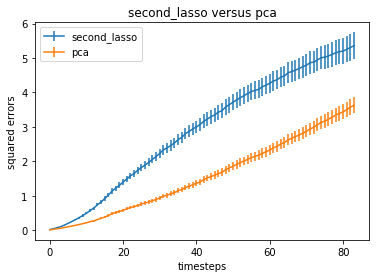

[0.10323793551209488, 4.1556872469121632e-08, 2.6735326236534768e-10, 6.244362157525722e-19, 5.5830796841800741e-23, 3.2665769326648773e-27, 2.8218616869091383e-28, 2.0905130493492148e-29, 2.7912384450904851e-30, 5.5366756021007918e-31, 9.0150866640526821e-32, 5.0338778480198802e-33, 2.1232361030520749e-34, 4.6298094806773821e-35, 6.7836974594260143e-35, 5.1285804725082042e-36, 5.1541322468097874e-36, 4.6101298682309685e-36, 3.8448454034860276e-36, 1.7908363793766826e-36, 3.8414946533533234e-37, 1.0681463060362763e-37, 1.672094782590059e-37, 2.9401183414243267e-37, 7.0400090710152849e-38, 2.4593065059975424e-37, 2.6096048354401784e-37, 1.4363608489934978e-37, 1.2594596796029298e-37, 1.3788781551015331e-37, 2.1381717740134925e-37, 7.7391186804509824e-37, 3.0817654211331882e-36, 1.050594286579699e-35, 1.7153015062160786e-35, 8.7645102834936665e-35, 6.2366872197801245e-35, 1.48566200527277e-34, 6.971167352820828e-34, 1.9667802217848711e-33, 4.6336696792213748e-33, 1.0368600115516428e-32, 

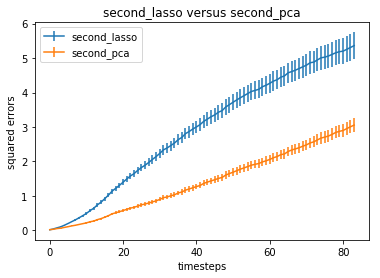

[4.9316722290638291e-68, 3.9056947296385526e-86, 7.122404420065223e-87, 8.2406707026323299e-88, 1.5996053567924758e-88, 1.176189856450025e-89, 1.9172958195191936e-90, 4.069074826934006e-91, 5.7632916823714995e-91, 4.6435881895166122e-90, 2.1359170310134501e-89, 1.2508013500709192e-88, 6.4014780035161004e-89, 1.5278633065337043e-87, 2.1864885989705737e-87, 1.4203503695923245e-85, 3.8260538007111687e-85, 5.3751455266805644e-83, 9.132055510169389e-82, 2.6810273405851022e-80, 3.6688378704927898e-78, 1.6970618759821848e-76, 1.8177771314566602e-74, 6.0098163427155491e-73, 9.470168026183022e-71, 2.0226710962675637e-69, 2.4375016730458046e-68, 1.3833933407069516e-66, 9.9667049623109656e-65, 2.0887339241410618e-63, 1.4711899366866825e-61, 3.6774410911992304e-59, 3.6111949104821616e-58, 2.2214599411918948e-56, 9.3756509766582517e-55, 1.5755615041981006e-53, 3.9298551814282314e-52, 5.9357051838361763e-51, 4.4424662529606868e-50, 1.7242649066771006e-48, 3.3538951533941291e-47, 1.9923747976911559e-

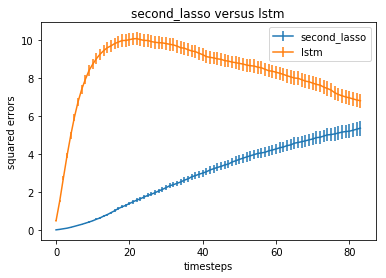

[3.535948579761221e-59, 6.4644217184159781e-60, 3.008343327588517e-58, 1.1111270394593157e-56, 2.4741690383950357e-55, 9.9912884732172261e-55, 8.776495959886682e-55, 6.0720248779687872e-54, 2.7397427562715069e-52, 1.0187910517302601e-50, 1.1440373293624265e-49, 6.4113403579070105e-48, 3.925552623019091e-46, 3.4123725657495678e-44, 4.0035451858303418e-43, 4.4598548360816166e-42, 2.5269101057774313e-40, 4.6956441529164314e-39, 1.4811728215927901e-37, 9.6361786583566409e-36, 1.3296599352690285e-33, 4.1224773415049766e-32, 3.0296242041915047e-31, 4.039091434798589e-29, 1.1212504154512859e-26, 1.0885868106474855e-24, 7.7335515831632306e-24, 2.7939373985698094e-22, 2.163510194569239e-21, 1.4615919030938978e-20, 2.6958332562785471e-19, 6.6062677644884212e-18, 5.5812172283699842e-17, 1.3818110942667809e-15, 4.9046692738652016e-14, 1.1276275299776661e-12, 2.2825666939646114e-11, 6.9923541418992538e-10, 5.06727886547583e-09, 9.0604692910395304e-08, 8.7597357459750553e-07, 8.9509426039666795e-06,

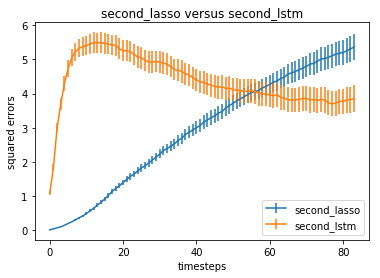

[0.00087510410806303771, 0.0031402530764839467, 0.0056757840977796859, 0.013970644156901647, 0.0088257368145230174, 0.0093432206921461348, 0.014596101398645887, 0.033306044726558175, 0.076965443899699323, 0.23288037069607051, 0.4998053586097454, 0.77710543690797307, 0.90372318082697478, 0.97530589863655182, 0.76079562949654267, 0.73878094664911798, 0.56460674392239263, 0.48561520689249082, 0.39592045821899569, 0.25620240359651814, 0.20992037605090247, 0.14866890910682345, 0.084968057109702705, 0.055468557347958081, 0.044435820392478356, 0.021080894928594357, 0.0090195841923751373, 0.0045648721544808068, 0.0027031015181759781, 0.0014904029642126631, 0.0010003158153231344, 0.0005452172268842878, 0.00025216627158348867, 8.320184366087554e-05, 3.7115442869274293e-05, 1.5961601356687379e-05, 1.028375519143588e-05, 6.8214783805072344e-06, 2.7823875528231563e-06, 1.2416062934826874e-06, 2.5862738691728811e-07, 9.3113338435255427e-08, 3.8741554508908976e-08, 8.922422380322898e-09, 3.9730258674

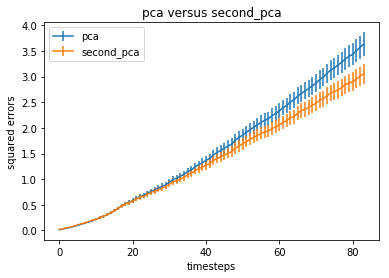

[5.1153531084086921e-70, 2.4184575364159194e-87, 6.3252729781747758e-88, 5.6073518379163878e-89, 5.3802914407705054e-90, 1.5240420198773016e-91, 1.1302947483429265e-92, 1.1652796679226048e-93, 8.4697381066158545e-94, 3.3048651249502401e-93, 6.8556652087693611e-93, 1.1854255111551094e-92, 2.5735172651674335e-93, 1.4215237737105037e-92, 1.0008545054123647e-92, 1.5735324828384125e-91, 1.4586839544672501e-91, 9.0638293494896332e-90, 1.211944989918635e-88, 1.2807923105097334e-87, 3.8785187084530592e-86, 4.5572127414382807e-85, 1.3047819501523112e-83, 1.5353452624260484e-82, 3.6324648739980856e-81, 1.3523024557558505e-80, 5.5332208778784957e-80, 5.0369143307634386e-79, 4.9141153112094117e-78, 2.8038607248134408e-77, 6.317566235231105e-76, 5.6700436840805233e-74, 4.4075566951956504e-73, 1.59320130520603e-71, 2.1902448277803125e-70, 8.9850956342940633e-70, 1.2769787859396321e-68, 1.0235695817997225e-68, 6.053082698182711e-68, 6.4830595086277516e-67, 8.2698131528077522e-66, 1.2151376368121552e-

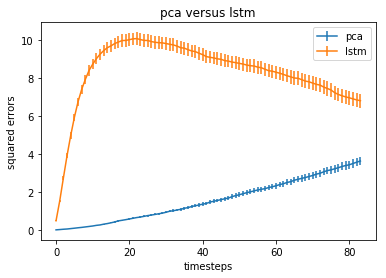

[1.5848856053603589e-59, 2.9757315397918921e-60, 1.6166214410099233e-58, 5.2075874234304841e-57, 8.3436163459522157e-56, 2.1908426079422851e-55, 1.4260291460608185e-55, 7.8073754850912108e-55, 2.0634744676900976e-53, 4.6619495541208908e-52, 3.6792053529613605e-51, 1.060143440336921e-49, 3.3578174707227205e-48, 9.5370397651320242e-47, 6.2165935276483155e-46, 2.5907304436194281e-45, 3.1644254626969978e-44, 1.9445378004126887e-43, 2.9761180021249218e-42, 5.9580844665192264e-41, 2.1094046422235735e-39, 1.6663793735455448e-38, 3.690369516159806e-38, 2.1744518610292715e-36, 1.4526850260498101e-34, 6.0285450835305666e-33, 1.6891506306335239e-32, 1.9891848215389935e-31, 4.4050986367394461e-31, 1.4189332861104021e-30, 1.1741988721357667e-29, 7.5559917957791025e-29, 4.0275284350799828e-28, 5.9465388458236437e-27, 9.4257757064726462e-26, 1.9399889030078647e-24, 5.2828231742650553e-23, 7.5789283426712493e-22, 5.6276756180219076e-21, 9.3514275976176978e-20, 1.5890729363310889e-18, 1.869469422049528

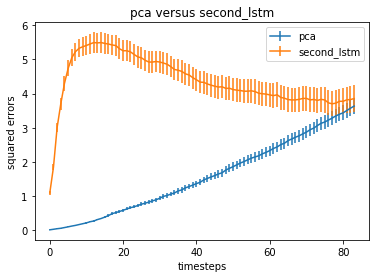

[4.0188335197210318e-67, 4.0026047392130996e-87, 7.0947490059165875e-88, 4.8110057630463064e-89, 4.6524706738259231e-90, 1.3674091243576292e-91, 1.000588818092879e-92, 9.5742154763587363e-94, 6.6287693234429507e-94, 2.4841263270034005e-93, 5.093793279324991e-93, 8.6427296515172424e-93, 1.7282288248621662e-93, 9.4075404124292078e-93, 5.6779321060245496e-93, 8.4699711181889414e-92, 6.7457162559145484e-92, 3.5141203983812345e-90, 3.8262768925770829e-89, 3.310920005945756e-88, 9.2579813477110902e-87, 9.3877041803948301e-86, 2.4262616455901003e-84, 2.3824786706956039e-83, 5.2553533047944289e-82, 1.562796464404618e-81, 5.006824704432923e-81, 3.647495924469233e-80, 3.1539995363124388e-79, 1.4872691619504854e-78, 2.6507885271316757e-77, 1.9327890824559897e-75, 1.1006872624403864e-74, 3.0023020925255061e-73, 2.948963335695747e-72, 9.2219801966347088e-72, 9.4097756974407583e-71, 5.1250737354426883e-71, 2.1197593374365723e-70, 1.5750003580409829e-69, 1.3178890327098663e-68, 1.3745191715428833e-67

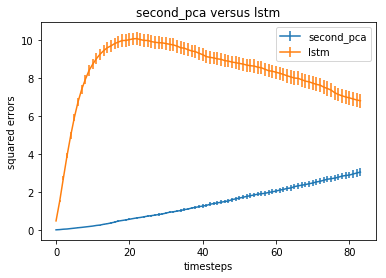

[9.9343223188231622e-59, 4.4183996856232447e-60, 2.0637662631054264e-58, 5.5931420479262352e-57, 9.1639152754831575e-56, 2.3824691796011915e-55, 1.5047615594854406e-55, 7.8407080132154628e-55, 1.9977880674967914e-53, 4.2841456312221583e-52, 3.2933628637328396e-51, 9.3983725215368803e-50, 2.9880741652702129e-48, 8.5595029758415736e-47, 5.4094025436434358e-46, 2.2333148863312409e-45, 2.6774170378325873e-44, 1.5845742760080643e-43, 2.2535341503013871e-42, 4.1404162494062566e-41, 1.4802994890379718e-39, 1.1145546817897458e-38, 2.311354219504263e-38, 1.3310568545309851e-36, 8.9025706506255638e-35, 3.3422603406586648e-33, 8.5756224799404392e-33, 9.1566876905837415e-32, 1.9068395837953404e-31, 5.7472775872652638e-31, 4.5749913836041962e-30, 2.7043072067145584e-29, 1.2888364279167019e-28, 1.5334608056917691e-27, 2.2297107887749902e-26, 4.0623631308336757e-25, 1.0824358732234584e-23, 1.4300023161999767e-22, 9.4683453860685299e-22, 1.3767704137746318e-20, 1.9857456032872682e-19, 2.23017174418160

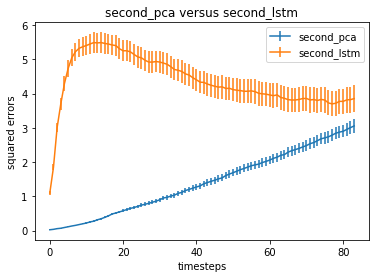

[5.7167726945291718e-29, 0.00026371920205111525, 0.060109189562102934, 0.24288626526302098, 0.0026392219663671696, 4.8348980317374585e-06, 5.5387559390576975e-09, 6.1235976875283384e-12, 2.1494246979353469e-14, 5.7576562073466279e-17, 1.314987628665781e-18, 6.0763671164876227e-20, 8.2770115396577803e-21, 7.0606469777883956e-22, 1.8688205295627886e-22, 2.6978291363493164e-23, 3.5051648807317871e-24, 1.1980885188547239e-24, 4.6486854268872148e-25, 1.510705913869147e-25, 5.7799394064081218e-26, 5.1890299889425084e-26, 2.6757010461221891e-26, 2.1191927112250643e-26, 2.1533528931633624e-26, 3.8936597935156671e-26, 2.3300114502901187e-26, 2.3058713511318061e-26, 5.1429936617070561e-26, 1.2141513731573577e-25, 2.5758903545540849e-25, 3.1753358369137985e-25, 5.1285984899789145e-25, 2.5453430798238538e-25, 2.3847588685272004e-25, 2.8876614346945089e-25, 1.346874101953505e-24, 8.2980076482775134e-25, 1.0030668977166078e-24, 8.2511029580943119e-25, 1.2419357416835616e-24, 2.5326038481951077e-24, 

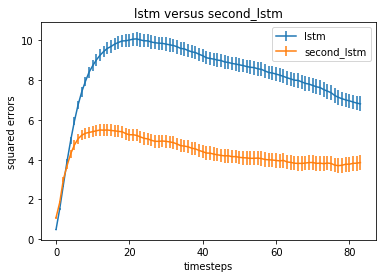

In [38]:
cigraphs(methods, facmaindept_mean, facmaindept_sem, facmaindept_sq, 60*7)